In [1]:
#Imports and Settings
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime
from operator import mul
import seaborn as sn
import random

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, 
f1_score, accuracy_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler

#Helper Functions
from helper import predict, confusion_matrix1, calculate_threshold_values, plot_roc
#Pandas Settings to Display Rows and Cols
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 10) 

#Matplotlib Style Settings
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

#Pandas Standaridzer for Float Formatting
#pd.options.display.float_format = '{:,.2f}'.format
#pd.reset_option('display.float_format')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
tqdm.pandas(desc="my bar!")

In [2]:
# Looping through data folder to concat CSV's into one big dataframe
# 1002400 rows in dataset
# 63 columns
# Reinitialize HERE

for i,name in tqdm(enumerate(glob.glob('data/CSV/*'))):
    if i == 0:
        df = pd.read_csv(name)
    df2 = pd.read_csv(name)
    concat = pd.concat([df,df2],ignore_index=True)
    df = concat

In [3]:
#Back Up Reinitilization 
data = df.copy()

In [4]:
# Reinitilize DF
%time df = data.copy()

CPU times: user 273 ms, sys: 382 ms, total: 655 ms
Wall time: 653 ms


In [5]:
data.head(1)

,M,LA_No,T_No,Classics_Request_ID,End_Of_Run,Start_Date,First_Date,Last_Date,Play_Dates,FRM,Release,Local,Media_Formats,Rental_Measure,Theatre,Status,Boxoffice,Boxoffice_Net,Film_Rental,To_Receive,Admissions,FRM_Perc,Terms_Perc,Price,Min_Max,MG_FF,Office,Customer_Reference,Film_Buyer,Buying_Circuit,Payer,Remark,Payer_Remark,DType,Aspect_Ratio,Sound_System,Seat_Type,Amenity,Frame_Rate,Resolution,Projection_Type,Licensor,L,Hire,Rem_,Rem_Date,Show,Media_Type,Dim_,LV,Division,Branch,TV_Market,Area,Circuit,City,Seeks_Run,No,Usage,VPF_Company,Sales,Screen,NENR
0,-,00081065-01,1,NaN,n,3/16/2018 00:00:00,3/16/2018 00:00:00,3/18/2018 00:00:00,03/16;03/17;03/18,ff,"LEGO NINJAGO MOVIE, THE",2066081.0,ENG.2.DIG.0.0.0.0,none,MARCUS ST. CLAIR 10,Approved,0.0,0.0,175.0,175.0,0,0.0,-,0,-,175.0,ENCINO OFFICE,NaN,"Kuhlman, Nicole",MARCUS THEATRES,MARCUS THEATRES,NaN,NaN,no,no,no,none,none,none,none,none,None,NaN,0.0,0.0,1/1/1950 00:00:00,Normal,no,-,non,EASTERN,ST. LOUIS,ST LOUIS,"ST. LOUIS, MO",MARCUS THEATRES,"FAIRVIEW HEIGHTS, IL",OTHER - Temp Close,( 1 ),1.0,Cinedigm 2,sgoyette,MARCUS ST. CLAIR 10,NaN


In [6]:
#Trimming off extraneous columns
df = df.iloc[:,1:57]
df = df.drop(['Classics_Request_ID','End_Of_Run','Play_Dates','Start_Date','Local','Rental_Measure','Boxoffice_Net',
              'Film_Rental','To_Receive','FRM_Perc','Min_Max','MG_FF','Price','Customer_Reference','Office',
             'Remark','Payer_Remark','DType','Aspect_Ratio','Sound_System','Seat_Type','Amenity','Frame_Rate',
             'Resolution','Projection_Type','Licensor','L','Hire','Rem_','Rem_Date','Media_Type','Dim_','LV','Circuit'],axis=1)
#Data Leakage
#df = df.drop('Admissions',axis=1)
df.head(2)

,LA_No,T_No,First_Date,Last_Date,FRM,Release,Media_Formats,Theatre,Status,Boxoffice,Admissions,Terms_Perc,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,TV_Market,Area,City,Seeks_Run
0,00081065-01,1,3/16/2018 00:00:00,3/18/2018 00:00:00,ff,"LEGO NINJAGO MOVIE, THE",ENG.2.DIG.0.0.0.0,MARCUS ST. CLAIR 10,Approved,0.0,0,-,"Kuhlman, Nicole",MARCUS THEATRES,MARCUS THEATRES,Normal,EASTERN,ST. LOUIS,ST LOUIS,"ST. LOUIS, MO","FAIRVIEW HEIGHTS, IL",OTHER - Temp Close
1,00085822-14,14,2/24/2018 00:00:00,2/24/2018 00:00:00,sp,"LEGO NINJAGO MOVIE, THE",ENG.2.DIG.0.0.0.0,KINGSWAY 2,Returns In,0.0,0,35,"PEREIRA, RUI",7061412 CANADA LTD,7061412 CANADA LTD,Normal,CANADIAN,TORONTO,TORONTO,"TORONTO, ON","TORONTO, ON #1 TORONTO, ON",LATE - Temp Close


In [7]:
#Drop any duplicate ID's
df.drop_duplicates('LA_No',inplace=True)

#Dropping any non SP payments
df = df[df['FRM']=='sp'] 

# Only looking at records with grosses returned
df = df[df['Status']=='Returns In']

df = df[df.Division != 'CLASSICS']

#Dropping 500 NAN media formats
df = df.dropna(axis=0)

#Not in YT Data
df = df[df.Release !='THEY SHALL NOT GROW OLD']
df = df[df.Release !='FANTASTIC BEASTS AND WHERE TO FIND THEM']

In [8]:
df['First_Date'] = pd.to_datetime(df['First_Date'])
df['Last_Date'] = pd.to_datetime(df['Last_Date'])

df['Boxoffice'] = df['Boxoffice'].astype(str)
df['Boxoffice'] = df['Boxoffice'].apply(lambda x: x.replace(',', ''))
df['Boxoffice'] = df['Boxoffice'].astype(float)
df['T_No'] = df['T_No'].astype(float)

# Removed Admissions because of data leakage
df['Admissions'] = df['Admissions'].astype(str)
df['Admissions'] = df['Admissions'].apply(lambda x: x.replace(',', ''))
df['Admissions'] = df['Admissions'].astype(float)


In [9]:
def format_assign(x):
    if 'IMAX' in x or 'IXD'in x or 'DIMX' in x:     
        return 'IMAX'
    if 'PLF' in x or 'PLD' in x:
        return 'PLF'
    elif '3D' in x:
        return '3D'
    else:
        return '2D'

def seeks_run(x):
    if 'FIRST' in x:
        return 'FIRST RUN'
    elif 'LATE' in x:
        return 'LATE RUN'
    elif 'SUB' in x:
        return 'SUB RUN'
    else:
        return 'OTHER'
    # Intermediate Run, Other-Temp Close, IMAX, Art House, Calendar, Classics

df['Media_Formats'] = df['Media_Formats'].astype(str)
df['Media_Formats'] = df['Media_Formats'].swifter.apply(format_assign)
df['Seeks_Run'] = df['Seeks_Run'].swifter.apply(seeks_run)

# Anonymizing Data

In [10]:
from faker import Faker

In [11]:
# Number of values to annoymize
# 6022 Theatres
# 4661 Film Buyer/Buying Circuit/Payer
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df[['Theatre','Film_Buyer','Buying_Circuit','Payer']].nunique())

Theatre           6001
Film_Buyer        1044
Buying_Circuit     795
Payer             2789
dtype: int64


In [12]:
confid_users = list(df.Payer.unique())
confid_users.extend(list(df.Buying_Circuit.unique()))
confid_users.extend(list(df.Film_Buyer.unique()))

In [13]:
distinct_confid = set(confid_users)

In [14]:
Faker.seed(2)
fake = Faker()
fake_names = []
for _ in tqdm(range(5300)):
    fake_names.append(fake.company())
fake_names = set(fake_names)
fake_names = list(fake_names)

In [15]:
confid_dict = dict.fromkeys(distinct_confid)
for key,value in tqdm(confid_dict.items()):
    confid_dict[key] = random.sample(fake_names,1)[0]

In [16]:
cinema_names = pd.read_csv('data/extra_data/Cinema_names.csv',header=None)

In [17]:
cinema_names;

In [18]:
cinema_list = []
for n in tqdm(range(0,674)):
    if len(cinema_names[0].apply(lambda x: x.split(' '))[n])>1:
        cinema_list.append(cinema_names[0].apply(lambda x: x.split(' '))[n][1])
    else:
        continue

In [19]:
suffixes = ['Theaters','Cinemas','Movies','Flicks','Screens','Forum','Marquee']
maccs_theatres = df['Theatre'].unique().tolist()
maccs_theatres_dict = dict.fromkeys(maccs_theatres)

In [20]:
for key,value in maccs_theatres_dict.items():
    maccs_theatres_dict[key] = random.choice(cinema_list) +' '+ random.choice(cinema_list) + ' '+ random.choice(suffixes) 

maccs_theatres_dict

{'KINGSWAY 2': 'Jump Capital Cinemas',
 'CANYON MEADOWS 10': 'Scribe Courses Screens',
 'RAINBOW 8 ': 'Champion Kingdom Cinemas',
 'MARCUS SHOWTIME 12': 'Chart Basement Theaters',
 'BLUE RIDGE 14': 'Guys Spirit Cinemas',
 'CINEMARK MOVIES 16': 'Classic Enjoy Marquee',
 'PICTURE SHOW 8': 'Beast Gurus Theaters',
 'WESTWOOD CINEMA 8': 'Bold Crossover Flicks',
 'MARCUS ST. CLAIR 10': 'Mystery Caster Movies',
 'MOVIES 10': 'Allure Beyond Cinemas',
 'MASTERS 7': 'Hunter Muno Flicks',
 'HOLLYWOOD USA 15': 'Lynx Mungo Cinemas',
 'NASA 8': 'Factor Ratchet Movies',
 'SUPER SAVER CINEMAS 6': 'Flower Scope Cinemas',
 'PICTURE SHOW 8 @ SUPERSTITION SPRINGS': 'Lush Division Theaters',
 'PALACE W CINEMA 8': 'Caster Live Forum',
 'MOVIES 12': 'Nexus Drift Theaters',
 'MOVIES 9': 'Exciting Mogul Movies',
 'COTTONWOOD 4': 'Vibe Rad Cinemas',
 'HOLLYWOOD SURREY 3': 'Head Mountains Theaters',
 'W BOYLSTON CINEMA 5': 'Only Elite Marquee',
 'PICTURE SHOW 6': 'Details Trust Flicks',
 'COVENTRY 13': 'Groups D

In [21]:
%time df['Theatre'].replace(maccs_theatres_dict,inplace=True)
%time df['Buying_Circuit'].replace(confid_dict,inplace=True)
%time df['Film_Buyer'].replace(confid_dict,inplace=True)
%time df['Payer'].replace(confid_dict,inplace=True)

CPU times: user 3min, sys: 3.21 s, total: 3min 3s
Wall time: 3min 3s
CPU times: user 1min 10s, sys: 2.12 s, total: 1min 12s
Wall time: 1min 12s
CPU times: user 1min 11s, sys: 2.03 s, total: 1min 13s
Wall time: 1min 13s
CPU times: user 1min 20s, sys: 2.34 s, total: 1min 22s
Wall time: 1min 22s


In [ ]:
test = df.query("Theatre=='Justice Dollar Movies' & action == 1.00 ").groupby('Release').agg({'Boxoffice':'sum','Admissions':'sum','T_No':'max'})
test

In [22]:
#Only opening week
ow_df = df[df['Seeks_Run']=='FIRST RUN'].sort_values(['Theatre','Release','T_No'])
ow_df = ow_df[ow_df['T_No']==1]
ow_df.reset_index(inplace=True)
ow_df.drop(['index','FRM','LA_No','Status','Last_Date','Terms_Perc','TV_Market','Area'],axis=1,inplace=True)


ow_df

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run
0,1.0,2018-01-26,12 STRONG,2D,About Ality Forum,2597.34,335.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN
1,1.0,2019-06-25,ANNABELLE COMES HOME,2D,About Ality Forum,3748.06,429.0,"Robinson, Kelly and Young","Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN
2,1.0,2017-08-10,ANNABELLE: CREATION,2D,About Ality Forum,3983.09,509.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN
3,1.0,2018-12-20,AQUAMAN (2018),2D,About Ality Forum,10548.82,999.0,"Simpson, Sanchez and Waller","Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN
4,1.0,2017-10-05,BLADE RUNNER 2049,2D,About Ality Forum,4157.42,396.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205419,1.0,2018-06-15,TAG (2018),2D,for Wise Marquee,4995.50,503.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN
205420,1.0,2018-07-27,TEEN TITANS GO! TO THE MOVIES,2D,for Wise Marquee,2174.50,263.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN
205421,1.0,2018-03-15,TOMB RAIDER,2D,for Wise Marquee,4293.00,442.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN
205422,1.0,2017-04-21,UNFORGETTABLE,2D,for Wise Marquee,1716.07,183.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN


In [23]:
#Total Opening Week Numbers
#with pd.option_context('display.float_format','{:,.2f}'):
ow_bo = ow_df.groupby('Release').sum()['Boxoffice']
ow_bo = ow_bo.astype(int)
ow_bo = ow_bo.reset_index()
ow_bo['Boxoffice_Total'] = ow_bo['Boxoffice']
ow_bo.drop('Boxoffice',axis=1,inplace=True)

ow_bo

,Release,Boxoffice_Total
0,12 STRONG,19892950
1,"15:17 TO PARIS, THE",17744384
2,ANNABELLE COMES HOME,39301786
3,ANNABELLE: CREATION,45340847
4,AQUAMAN (2018),119892164
...,...,...
49,TAG (2018),22798241
50,TEEN TITANS GO! TO THE MOVIES,16205368
51,TOMB RAIDER,27926483
52,UNFORGETTABLE,6497468


# Opening Weekend DataFrame

In [90]:
ow_data = ow_df.merge(ow_bo,how='left',left_on='Release',right_on='Release')
ow_data['perc_of_bo'] = (ow_data.Boxoffice/ow_data.Boxoffice_Total).astype(float)
ow_data['perc_of_bo'] = round(ow_data['perc_of_bo'],5)
ow_data.head(1)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run,Boxoffice_Total,perc_of_bo
0,1.0,2018-01-26,12 STRONG,2D,About Ality Forum,2597.34,335.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,19892950,0.00013


# Baseline with average of entire data set, of all movies, all theatres, first 3 weeks

In [539]:

ow_data['over_index'] = ow_data['perc_of_bo']-ow_data.describe()['perc_of_bo'].loc['mean']
ow_data['over_index'] = ow_data['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_data = ow_data[ow_data['T_No']==1]
ow_data = ow_data[ow_data['Seeks_Run'] == 'FIRST RUN']
ow_data.head()


,T_No,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run,Boxoffice_Total,perc_of_bo,over_index
0,1.0,12 STRONG,2D,About Boards Flicks,1737.0,261.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,19892950,0.00009,0
1,1.0,"15:17 TO PARIS, THE",2D,About Boards Flicks,1478.5,221.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,17744384,0.00008,0
2,1.0,ANNABELLE COMES HOME,2D,About Boards Flicks,2903.5,404.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,39301786,0.00007,0
3,1.0,ANNABELLE: CREATION,2D,About Boards Flicks,3348.5,454.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,45340847,0.00007,0
4,1.0,AQUAMAN (2018),2D,About Boards Flicks,8327.5,1196.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,119892164,0.00007,0


In [540]:
ow_data['over_index'].value_counts()

0    131482
1     73942
Name: over_index, dtype: int64

In [541]:
ow_data.groupby('Release')['over_index'].value_counts()


Release               over_index
12 STRONG             0             1798
                      1             1496
15:17 TO PARIS, THE   0             1771
                      1             1526
ANNABELLE COMES HOME  0             2560
                                    ... 
TOMB RAIDER           1             1346
UNFORGETTABLE         1             1405
                      0             1061
WONDER WOMAN          0             3880
                      1             1350
Name: over_index, Length: 108, dtype: int64

# TMDb Movie Data

In [27]:
wb_list = df['Release'].unique().tolist()
wb_list

['LEGO NINJAGO MOVIE, THE',
 'TEEN TITANS GO! TO THE MOVIES',
 'IT (2017)',
 "ISN'T IT ROMANTIC",
 '15:17 TO PARIS, THE',
 'PADDINGTON 2',
 'SUN IS ALSO A STAR, THE',
 'KING ARTHUR: LEGEND OF THE SWORD',
 'EVERYTHING, EVERYTHING',
 'RAMPAGE (2018)',
 'LIFE OF THE PARTY',
 'JOKER',
 'SMALLFOOT',
 'READY PLAYER ONE',
 'IT CHAPTER TWO',
 'JUSTICE LEAGUE (2017)',
 'CHIPS (2017)',
 'TAG (2018)',
 'CRAZY RICH ASIANS',
 'HOUSE, THE (2017)',
 'SHAZAM! (2019)',
 'NUN, THE',
 '12 STRONG',
 'SHAFT (2074539)',
 'DUNKIRK (2017)',
 'RICHARD JEWELL',
 'DOCTOR SLEEP (2019)',
 'UNFORGETTABLE',
 'GAME NIGHT',
 'CURSE OF LA LLORONA, THE',
 'GOLDFINCH, THE',
 'STAR IS BORN, A (2024779)',
 'FATHER FIGURES',
 'TOMB RAIDER',
 'KITCHEN, THE',
 'MEG, THE',
 'FIST FIGHT',
 'LEGO BATMAN MOVIE, THE',
 'BLINDED BY THE LIGHT (2083623)',
 "OCEAN'S 8",
 'WONDER WOMAN',
 'POKEMON DETECTIVE PIKACHU',
 'MULE, THE',
 'GOOD LIAR, THE',
 'AQUAMAN (2018)',
 'LEGO MOVIE 2, THE: THE SECOND PART',
 'MOTHERLESS BROOKLYN',
 'GEO

In [28]:
clean = []
for title in wb_list:
    save = title.split("(")
    clean.append(save[0])

In [29]:
clean;

In [30]:
import difflib
import itertools
def get_close_matches_icase(word, possibilities, *args, **kwargs):
    """ Case-insensitive version of difflib.get_close_matches """
    lword = word.lower()
    lpos = {}
    for p in possibilities:
        if p.lower() not in lpos:
            lpos[p.lower()] = [p]
        else:
            lpos[p.lower()].append(p)
    lmatches = difflib.get_close_matches(lword, lpos.keys(), *args, **kwargs)
    ret = [lpos[m] for m in lmatches]
    ret = itertools.chain.from_iterable(ret)
    return set(ret)

In [117]:
genre_df = pd.read_csv('data/extra_data/wb_df.csv')
genre_df['title'] = genre_df['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("{'",''))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("'}",''))

#Matching between TMDb and WB
genre_df.at[9,'title'] = "HOUSE, THE"
genre_df.at[29,'title'] = "MEG, THE"
genre_df.at[31,'title'] = "NUN, THE"
genre_df.at[35,'title'] = "MULE, THE"
genre_df.at[44,'title'] = "SHAFT (2074539)"
genre_df = genre_df[genre_df.title !='They Shall Not Grow Old']
genre_df['title'] = genre_df['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("{'",''))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("'}",''))
genre_df.at[12,'title'] = "IT (2017)"
genre_df.at[38,'title'] = "ISN'T IT ROMANTIC"
genre_df.at[27,'title'] = "OCEAN'S 8"

genre_df = genre_df.drop(['genre_ids','Unnamed: 0','adult','id','original_language','popularity','video','vote_average','vote_count'],axis=1)
# Adding OW field
genre_df = genre_df.merge(ow_bo,how='left',left_on='title',right_on='Release')

#with pd.option_context("display.max_rows", 1000):
#    display(genre_df)

In [118]:

# Adding Comp Library Fields
comp_library = pd.read_csv('data/Comparison Library - Test.xlsx - Database.csv')
comp_library = comp_library[['TITLE','Dist','# of Runs','Genre','Rating','Season','WIDE                --------              Open Date']]
comp_library = comp_library[comp_library['Dist']=='WB']

comp_library['release_date'] = pd.to_datetime(comp_library['WIDE                --------              Open Date'])
comp_library.drop('WIDE                --------              Open Date',axis=1,inplace=True)
comp_library['year'] = comp_library['release_date'].dt.year
comp_library = comp_library[comp_library['year']>=2017]
comp_library = comp_library[comp_library['year']<2020]

comp_library['title'] = comp_library['TITLE'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.3)))
comp_library['title'] = comp_library['title'].apply(lambda x: x.replace("{'",''))
comp_library['title'] = comp_library['title'].apply(lambda x: x.replace("'}",''))


comp_library.drop(index=[90,124,132,133,231,254,259,269,279,291,300,406,421,450,638],axis=0,inplace=True)
comp_library.at[188,'TITLE'] = 'SHAFT (2074539)'
comp_library.at[188,'title'] = 'SHAFT (2074539)'
comp_library.at[248,'title'] = "ISN'T IT ROMANTIC"
comp_library.at[396,'title'] = "OCEAN'S 8"

#with pd.option_context("display.max_rows", 1000):
#    display(comp_library)

In [119]:
genre_df = comp_library.merge(genre_df,how='right',left_on='title',right_on='title',suffixes=('_x','_y'))
#Dropping TSNGO from Movie Description
genre_df.drop(36,axis=0,inplace=True)
genre_df.reset_index(inplace=True)
genre_df.drop('index',axis=1,inplace=True)
genre_df['# of Runs'] = genre_df['# of Runs'].apply(lambda x: x.replace(',',''))
genre_df['# of Runs'] = genre_df['# of Runs'].astype(int)

#Save Overview for NLP
movie_text = genre_df['overview']

genre_df.drop(['overview','release_date_x','release_date_y','Release','revenue'],axis=1,inplace=True)
genre_df.at[32,'budget'] = 80000000 #Smallfoot
genre_df.at[41,'budget'] = 9000000 #Sun is also a Star
genre_df.at[46,'budget'] = 15000000 #Blinded by the Light
#genre_df.at[11,'budget'] = 30000000 #Shaft

#with pd.option_context("display.max_rows", 1000):
#    display(genre_df)

In [120]:
genre_df

,TITLE,Dist,# of Runs,Genre,Rating,Season,year,title,budget,runtime,Boxoffice_Total
0,Chips,WB,2464,Comedy,R,Spring,2017,CHIPS (2017),25000000,100,10467132
1,Lego Batman Movie - 3D/IMAX,WB,4088,Animation,PG,Winter,2017,"LEGO BATMAN MOVIE, THE",80000000,104,56793423
2,Fist Fight,WB,3185,Comedy,R,Winter,2017,FIST FIGHT,22000000,91,16779504
3,Unforgettable,WB,2417,Suspense/Thrill,R,Spring,2017,UNFORGETTABLE,12000000,100,6497468
4,Kong: Skull Island - 3D/IMAX,WB,3846,Action/Adventure,PG13,Spring,2017,KONG: SKULL ISLAND,185000000,118,72932544
...,...,...,...,...,...,...,...,...,...,...,...
49,Joker - IMAX,WB,4374,Drama,R,Fall,2019,JOKER,55000000,122,123730399
50,Doctor Sleep,WB,3855,Horror,R,Thanksgiving,2019,DOCTOR SLEEP (2019),45000000,152,17133477
51,Motherless Brooklyn,WB,1342,Drama,R,Thanksgiving,2019,MOTHERLESS BROOKLYN,26000000,145,5165694
52,Good Liar,WB,2439,Drama,R,Thanksgiving,2019,"GOOD LIAR, THE",10000000,109,8468042


In [39]:
theatre_genre = ow_data.copy()
theatre_genre = theatre_genre.merge(genre_df[['title','Genre']], how='left',left_on='Release',right_on='title')
theatre_genre = round(theatre_genre.groupby(['Theatre','Genre'],as_index=False)['Boxoffice'].mean())

In [40]:
theatre_genre

,Theatre,Genre,Boxoffice
0,About Ality Forum,Action/Adventure,5817.0
1,About Ality Forum,Animation,4708.0
2,About Ality Forum,Children/Family,1487.0
3,About Ality Forum,Comedy,3325.0
4,About Ality Forum,Drama,5800.0
...,...,...,...
39393,for Wise Marquee,Horror,5307.0
39394,for Wise Marquee,Romantic Comedy,4105.0
39395,for Wise Marquee,Romantic Drama,2347.0
39396,for Wise Marquee,Sci-Fi/Fantasy,5472.0


In [91]:
genre_avg = ow_data.copy()
genre_avg = genre_avg.merge(genre_df[['Genre','title']], how='left',left_on='Release',right_on='title')
genre_avg = genre_avg.groupby('Genre',as_index=False)['Boxoffice'].mean()
genre_avg

,Genre,Boxoffice
0,Action/Adventure,14388.873392
1,Animation,7923.813965
2,Children/Family,4392.015134
3,Comedy,6126.013828
4,Drama,8270.283450
5,Horror,15646.827127
6,Romantic Comedy,9859.986026
7,Romantic Drama,3835.829130
8,Sci-Fi/Fantasy,11228.077658
9,Suspense/Thrill,2634.820969


In [57]:
theatre_avg = ow_data.copy()
theatre_avg = theatre_avg.merge(genre_df['title'], how='left',left_on='Release',right_on='title')
theatre_avg = round(theatre_avg.groupby('Theatre',as_index=False)['Boxoffice'].mean())
theatre_avg

,Theatre,Boxoffice
0,About Ality Forum,4994.0
1,About Bargains Cinemas,11127.0
2,About Plus Cinemas,20673.0
3,About Point Theaters,3227.0
4,About Serendipity Theaters,2603.0
...,...,...
4596,for Share Marquee,19671.0
4597,for Share Screens,17580.0
4598,for Spotlight Cinemas,6579.0
4599,for Wise Cinemas,2009.0


In [79]:
theatre_perc = ow_data.copy()
theatre_perc = theatre_perc.merge(genre_df[['title','Genre']], how='left',left_on='Release',right_on='title')
theatre_perc = theatre_perc.groupby(['Theatre','Genre'],as_index=False)['perc_of_bo'].mean()
theatre_perc

,Theatre,Genre,perc_of_bo
0,About Ality Forum,Action/Adventure,0.000099
1,About Ality Forum,Animation,0.000150
2,About Ality Forum,Children/Family,0.000090
3,About Ality Forum,Comedy,0.000155
4,About Ality Forum,Drama,0.000126
...,...,...,...
39393,for Wise Marquee,Horror,0.000073
39394,for Wise Marquee,Romantic Comedy,0.000105
39395,for Wise Marquee,Romantic Drama,0.000215
39396,for Wise Marquee,Sci-Fi/Fantasy,0.000120


In [96]:
genre_df

,TITLE,Dist,# of Runs,Genre,Rating,Season,year,title,budget,runtime,Boxoffice_Total
0,Chips,WB,"2,464",Comedy,R,Spring,2017,CHIPS (2017),25000000,100,10467132
1,Lego Batman Movie - 3D/IMAX,WB,"4,088",Animation,PG,Winter,2017,"LEGO BATMAN MOVIE, THE",80000000,104,56793423
2,Fist Fight,WB,"3,185",Comedy,R,Winter,2017,FIST FIGHT,22000000,91,16779504
3,Unforgettable,WB,"2,417",Suspense/Thrill,R,Spring,2017,UNFORGETTABLE,12000000,100,6497468
4,Kong: Skull Island - 3D/IMAX,WB,"3,846",Action/Adventure,PG13,Spring,2017,KONG: SKULL ISLAND,185000000,118,72932544
...,...,...,...,...,...,...,...,...,...,...,...
49,Joker - IMAX,WB,"4,374",Drama,R,Fall,2019,JOKER,55000000,122,123730399
50,Doctor Sleep,WB,"3,855",Horror,R,Thanksgiving,2019,DOCTOR SLEEP (2019),45000000,152,17133477
51,Motherless Brooklyn,WB,"1,342",Drama,R,Thanksgiving,2019,MOTHERLESS BROOKLYN,26000000,145,5165694
52,Good Liar,WB,"2,439",Drama,R,Thanksgiving,2019,"GOOD LIAR, THE",10000000,109,8468042


In [103]:
ow_genreavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_genreavg = ow_genreavg.merge(genre_avg,how='left',on='Genre',suffixes=['_loc','_avg'])

ow_genreavg['over_index'] = ow_genreavg['Boxoffice_loc']-ow_genreavg['Boxoffice_avg']
ow_genreavg['over_index'] = ow_genreavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_genreavg.tail(5)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run,Boxoffice_Total,perc_of_bo,title,Genre,Boxoffice_avg,over_index
205419,1.0,2018-06-15,TAG (2018),2D,for Wise Marquee,4995.50,503.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN,22798241,0.00022,TAG (2018),Comedy,6126.013828,0
205420,1.0,2018-07-27,TEEN TITANS GO! TO THE MOVIES,2D,for Wise Marquee,2174.50,263.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN,16205368,0.00013,TEEN TITANS GO! TO THE MOVIES,Animation,7923.813965,0
205421,1.0,2018-03-15,TOMB RAIDER,2D,for Wise Marquee,4293.00,442.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN,27926483,0.00015,TOMB RAIDER,Action/Adventure,14388.873392,0
205422,1.0,2017-04-21,UNFORGETTABLE,2D,for Wise Marquee,1716.07,183.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN,6497468,0.00026,UNFORGETTABLE,Suspense/Thrill,2634.820969,0
205423,1.0,2017-06-02,WONDER WOMAN,2D,for Wise Marquee,27476.50,3013.0,Roman Group,"Anderson, Gonzalez and Dougherty","Anderson, Gonzalez and Dougherty",Normal,SOUTHERN,MEMPHIS,"GERMANTOWN, TN",FIRST RUN,134703961,0.00020,WONDER WOMAN,Action/Adventure,14388.873392,1


In [105]:
ow_genreavg['over_index'].value_counts()

0    144280
1     61144
Name: over_index, dtype: int64

In [83]:
test = ow_data.copy()

In [85]:
'''
n = test.groupby('Theatre')['Boxoffice_loc'].transform('count')
m = test.groupby('Theatre')['Boxoffice_loc'].transform('mean')
test['avg_loc_bo'] = (m*n - test['Boxoffice_loc'])/(n-1)

test.query("Theatre == 'About Ality Forum'")
'''

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run,Boxoffice_Total,perc_of_bo,title,Genre,Boxoffice_avg,avg_loc_bo
0,1.0,2018-01-26,12 STRONG,2D,About Ality Forum,2597.34,335.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,19892950,0.00013,12 STRONG,Drama,4994.0,5048.259545
1,1.0,2019-06-25,ANNABELLE COMES HOME,2D,About Ality Forum,3748.06,429.0,"Robinson, Kelly and Young","Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,39301786,0.00010,ANNABELLE COMES HOME,Horror,4994.0,5022.106818
2,1.0,2017-08-10,ANNABELLE: CREATION,2D,About Ality Forum,3983.09,509.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,45340847,0.00009,ANNABELLE: CREATION,Horror,4994.0,5016.765227
3,1.0,2018-12-20,AQUAMAN (2018),2D,About Ality Forum,10548.82,999.0,"Simpson, Sanchez and Waller","Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,119892164,0.00009,AQUAMAN (2018),Action/Adventure,4994.0,4867.544091
4,1.0,2017-10-05,BLADE RUNNER 2049,2D,About Ality Forum,4157.42,396.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,39806368,0.00010,BLADE RUNNER 2049,Sci-Fi/Fantasy,4994.0,5012.803182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,1.0,2018-06-15,TAG (2018),2D,About Ality Forum,2230.72,275.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,22798241,0.00010,TAG (2018),Comedy,4994.0,5056.591818
41,1.0,2018-07-27,TEEN TITANS GO! TO THE MOVIES,2D,About Ality Forum,2478.69,350.0,"Simpson, Sanchez and Waller","Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,16205368,0.00015,TEEN TITANS GO! TO THE MOVIES,Animation,4994.0,5050.956136
42,1.0,2018-03-16,TOMB RAIDER,2D,About Ality Forum,4000.14,391.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,27926483,0.00014,TOMB RAIDER,Action/Adventure,4994.0,5016.377727
43,1.0,2017-09-01,WONDER WOMAN,2D,About Ality Forum,761.43,93.0,Simmons Inc,"Garrison, Gardner and Jones","Peterson, Collins and Martin",Normal,CANADIAN,WINNIPEG,"MOOSE JAW, SA",FIRST RUN,134703961,0.00001,WONDER WOMAN,Action/Adventure,4994.0,5089.984773


In [1346]:
round(genre_df.pivot_table(values='Boxoffice_Total',index=['Genre'],aggfunc='mean'))

,Boxoffice_Total
Genre,
Action/Adventure,61418906.0
Animation,32180193.0
Children/Family,16329512.0
Comedy,21089415.0
Drama,29253646.0
Horror,62678954.0
Romantic Comedy,39272324.0
Romantic Drama,9591490.0
Sci-Fi/Fantasy,46983890.0


In [1226]:
movie_data = pd.read_csv('data/extra_data/wb_df.csv')
movie_data = movie_data.drop(['Unnamed: 0','adult','id','original_language','popularity','video','vote_average','vote_count'],axis=1)
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])
movie_data['month'] = movie_data['release_date'].dt.month
#movie_data['weeknum'] = movie_data['release_date'].dt.week


from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect_trans = vect.fit_transform(movie_data.genre_ids)
count_df = pd.DataFrame(data=vect_trans.todense(), columns=vect.get_feature_names())
#count_df.index += 1
movies = pd.merge(movie_data, count_df, left_index=True, right_index=True)
movies = movies.drop(['genre_ids','release_date','revenue'],axis=1)

#Matching between TMDb and WB
movies.at[9,'title'] = "HOUSE, THE"
movies.at[29,'title'] = "MEG, THE"
movies.at[31,'title'] = "NUN, THE"
movies.at[35,'title'] = "MULE, THE"
movies.at[44,'title'] = "SHAFT (2074539)"
movies = movies[movies.title !='They Shall Not Grow Old']
movies['title'] = movies['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
movies['title'] = movies['title'].apply(lambda x: x.replace("{'",''))
movies['title'] = movies['title'].apply(lambda x: x.replace("'}",''))
movies.at[12,'title'] = "IT (2017)"
movies.at[38,'title'] = "ISN'T IT ROMANTIC"
movies.at[27,'title'] = "OCEAN'S 8"

movies.at[32,'budget'] = 80000000
movies.at[42,'budget'] = 9000000
movies.at[47,'budget'] = 15000000

''' 
Action/Adventure
Family/Animation
Romance/Comedy
Drama
Crime/Thriller
Sci Fi/Fantasy
Horror
Other
'''

movies['act/adv'] = movies['action']+movies['adventure']
movies['act/adv'] = movies['act/adv'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['ani/fam'] = movies['animation']+movies['family']
movies['ani/fam'] = movies['ani/fam'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['rom/com'] = movies['romance']+movies['comedy']
movies['rom/com'] = movies['rom/com'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['crime_thriler'] = movies['crime']+movies['thriller']
movies['crime_thriler'] = movies['crime_thriler'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['sci-fi/fan'] = movies['science']+movies['fiction']+movies['fantasy']
movies['sci-fi/fan'] = movies['sci-fi/fan'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['old_war'] = movies['history']+movies['war']
movies['old_war'] = movies['old_war'].swifter.apply(lambda x: 1 if x>=1 else 0)

movies.drop(['action','adventure','animation','family','romance','comedy','crime','thriller','science','fiction','fantasy','history','war'],axis=1, inplace=True)
#with pd.option_context("display.max_rows", 1000):
#    display(movies)

# YT Views to OW

In [123]:
yt_views = pd.read_csv('data/extra_data/OW to YT - BoxOfficeReport - WB 2017-2019.csv')
yt_views['Release Date'] = pd.to_datetime(yt_views['Release Date'])
yt_views = yt_views[yt_views['Release Date']<'2020']

#Dropping Live by Night rom 2016
yt_views.drop(63,axis=0,inplace=True)

yt_views['Film (Distributor)'] =yt_views['Film (Distributor)'].apply(lambda x: x.split('(')[0])
#yt_views['Film'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("{'",''))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("'}",''))

yt_views.at[25,'Film (Distributor)'] = "ISN'T IT ROMANTIC"
yt_views.at[36,'Film (Distributor)'] = "OCEAN'S 8"
yt_views.at[53,'Film (Distributor)'] = "HOUSE, THE (2017)"

#yt_views = yt_views.reset_index()
yt_display = yt_views.copy()
#yt_views.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views','Film'],axis=1,inplace=True)


with pd.option_context("display.max_rows", 1000):
#    yt_display.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views'],axis=1,inplace=True)
    display(yt_views)

,Film (Distributor),Release Date,Trailer Link,Opening Weekend,YT Trailer Views,OW to YT
9,RICHARD JEWELL,2019-12-13,YouTube Trailer,$4.680 M,8.967 M,0.522
10,"GOOD LIAR, THE",2019-11-15,YouTube Trailer,$5.605 M,10.921 M,0.513
11,DOCTOR SLEEP (2019),2019-11-08,YouTube Trailer,$14.114 M,18.626 M,0.758
12,MOTHERLESS BROOKLYN,2019-11-01,YouTube Trailer,$3.500 M,6.841 M,0.512
13,JOKER,2019-10-04,YouTube Trailer,$96.202 M,112.868 M,0.852
14,"GOLDFINCH, THE",2019-09-13,YouTube Trailer,$2.679 M,10.909 M,0.246
15,IT CHAPTER TWO,2019-09-06,YouTube Trailer,$91.062 M,67.189 M,1.355
16,BLINDED BY THE LIGHT (2083623),2019-08-16,YouTube Trailer,$4.333 M,5.688 M,0.762
17,"KITCHEN, THE",2019-08-09,YouTube Trailer,$5.527 M,11.763 M,0.470
18,ANNABELLE COMES HOME,2019-06-26,YouTube Trailer,$20.270 M,24.632 M,0.823


In [139]:
full_movie = genre_df.merge(yt_views,how='left',left_on='title',right_on='Film (Distributor)')

full_movie.drop(['Dist','TITLE','Release Date','Trailer Link','title','YT Trailer Views','Opening Weekend','year'],axis=1,inplace=True)

with pd.option_context("display.max_rows", 1000):
    display(full_movie)

,# of Runs,Genre,Rating,Season,budget,runtime,Boxoffice_Total,Film (Distributor),OW to YT
0,2464,Comedy,R,Spring,25000000,100,10467132,CHIPS (2017),1.091
1,4088,Animation,PG,Winter,80000000,104,56793423,"LEGO BATMAN MOVIE, THE",1.697
2,3185,Comedy,R,Winter,22000000,91,16779504,FIST FIGHT,1.361
3,2417,Suspense/Thrill,R,Spring,12000000,100,6497468,UNFORGETTABLE,0.888
4,3846,Action/Adventure,PG13,Spring,185000000,118,72932544,KONG: SKULL ISLAND,1.728
5,3061,Comedy,PG13,Spring,25000000,96,17648456,GOING IN STYLE (2017),4.511
6,3702,Action/Adventure,PG13,Summer,175000000,126,20286533,KING ARTHUR: LEGEND OF THE SWORD,0.545
7,2801,Romantic Drama,PG13,Summer,10000000,96,15756271,"EVERYTHING, EVERYTHING",2.113
8,4165,Action/Adventure,PG13,Summer,149000000,141,134703961,WONDER WOMAN,1.226
9,3134,Comedy,R,Summer,40000000,88,14032720,"HOUSE, THE (2017)",1.421


In [140]:
full_movie

,# of Runs,Genre,Rating,Season,budget,runtime,Boxoffice_Total,Film (Distributor),OW to YT
0,2464,Comedy,R,Spring,25000000,100,10467132,CHIPS (2017),1.091
1,4088,Animation,PG,Winter,80000000,104,56793423,"LEGO BATMAN MOVIE, THE",1.697
2,3185,Comedy,R,Winter,22000000,91,16779504,FIST FIGHT,1.361
3,2417,Suspense/Thrill,R,Spring,12000000,100,6497468,UNFORGETTABLE,0.888
4,3846,Action/Adventure,PG13,Spring,185000000,118,72932544,KONG: SKULL ISLAND,1.728
...,...,...,...,...,...,...,...,...,...
49,4374,Drama,R,Fall,55000000,122,123730399,JOKER,0.852
50,3855,Horror,R,Thanksgiving,45000000,152,17133477,DOCTOR SLEEP (2019),0.758
51,1342,Drama,R,Thanksgiving,26000000,145,5165694,MOTHERLESS BROOKLYN,0.512
52,2439,Drama,R,Thanksgiving,10000000,109,8468042,"GOOD LIAR, THE",0.513


In [ ]:
iter2 = ow_genreavg[['Media_Formats','Release','Division','Genre','over_index']]
iter2 = iter2.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','budget','runtime','OW to YT']],how='left',left_on='Release',right_on='Film (Distributor)')
iter2_1hot = pd.get_dummies(data=iter2,columns=['Media_Formats','Division','Genre','Rating','Season'],drop_first=True)
iter2_full = iter2.merge(iter2_1hot,how='left',left_on='Release',right_on='Release')
iter2_full

In [542]:
#SMALLER TEST SUBSET
test = ow_data.copy()
test.drop(columns=['Theatre','Boxoffice','Admissions','Film_Buyer','Buying_Circuit','Payer','Branch','City','Seeks_Run','Boxoffice_Total'],inplace=True)
test

,T_No,Release,Media_Formats,Show,Division,perc_of_bo,over_index
0,1.0,12 STRONG,2D,Normal,EASTERN,0.00009,0
1,1.0,"15:17 TO PARIS, THE",2D,Normal,EASTERN,0.00008,0
2,1.0,ANNABELLE COMES HOME,2D,Normal,EASTERN,0.00007,0
3,1.0,ANNABELLE: CREATION,2D,Normal,EASTERN,0.00007,0
4,1.0,AQUAMAN (2018),2D,Normal,EASTERN,0.00007,0
...,...,...,...,...,...,...,...
205419,1.0,TAG (2018),2D,Normal,WESTERN,0.00022,0
205420,1.0,TEEN TITANS GO! TO THE MOVIES,2D,Normal,WESTERN,0.00017,0
205421,1.0,TOMB RAIDER,2D,Normal,WESTERN,0.00014,0
205422,1.0,UNFORGETTABLE,2D,Normal,WESTERN,0.00015,0


In [543]:
test_1hot = pd.get_dummies(data=test,columns=['Media_Formats','Show','Division'],drop_first=True)

test_1hot

,T_No,Release,perc_of_bo,over_index,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN
0,1.0,12 STRONG,0.00009,0,0,0,0,1,0,0
1,1.0,"15:17 TO PARIS, THE",0.00008,0,0,0,0,1,0,0
2,1.0,ANNABELLE COMES HOME,0.00007,0,0,0,0,1,0,0
3,1.0,ANNABELLE: CREATION,0.00007,0,0,0,0,1,0,0
4,1.0,AQUAMAN (2018),0.00007,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
205419,1.0,TAG (2018),0.00022,0,0,0,0,0,0,1
205420,1.0,TEEN TITANS GO! TO THE MOVIES,0.00017,0,0,0,0,0,0,1
205421,1.0,TOMB RAIDER,0.00014,0,0,0,0,0,0,1
205422,1.0,UNFORGETTABLE,0.00015,0,0,0,0,0,0,1


In [1040]:
test_full = test_1hot.merge(full_movie,how='left',left_on='Release',right_on='title')


In [ ]:
test_full.drop(columns=['Release','title','T_No','perc_of_bo'],inplace=True)
#test_full = test_full.fillna(0)
test_full


## Combined with Movie Meta Data

In [103]:
def plot_corr(df):
    corr = df.corr()
    sn.heatmap(corr,annot=True,cmap='coolwarm',alpha=0.8)
    plt.title('Correlation Matrix')
    plt.show

In [415]:
#One Hot Encoded Theatre information, 5993x2773

theatre_df = df.groupby('Theatre')[df.columns[-9:]].first()
theatre_df.drop(['Show','Branch','Area','City'],axis=1, inplace=True)
theatre_df = pd.get_dummies(data=theatre_df,columns=['Buying_Circuit','Payer','Division','TV_Market','Seeks_Run'],drop_first=True)
theatre_df.head(1)

Buying_Circuit_Adams, Sampson and Monroe  Buying_Circuit_Adams-Baker  Buying_Circuit_Adkins LLC  Buying_Circuit_Alexander LLC  Buying_Circuit_Alexander-Benjamin  Buying_Circuit_Alexander-Hughes  Buying_Circuit_Allen, Wilson and Day  Buying_Circuit_Alvarado-Johnson  Buying_Circuit_Alvarez, Jimenez and Garrett  Buying_Circuit_Alvarez-Gomez  Buying_Circuit_Anderson, French and Wright  Buying_Circuit_Anderson, Norris and Dawson  Buying_Circuit_Anderson-Hess  Buying_Circuit_Andrade Group  Buying_Circuit_Andrade Ltd  Buying_Circuit_Andrews Group  Buying_Circuit_Austin, Brewer and Ayers  Buying_Circuit_Avila-Kelley  Buying_Circuit_Bailey-Hardy  Buying_Circuit_Baker Group  Buying_Circuit_Baker, Chavez and Taylor  Buying_Circuit_Baker, Harris and Avery  Buying_Circuit_Baldwin Inc  Buying_Circuit_Barnes and Sons  Buying_Circuit_Barnes-Ray  Buying_Circuit_Barnes-Wagner  Buying_Circuit_Barnett-West  Buying_Circuit_Barr, Lopez and Lopez  Buying_Circuit_Barton, Henry and Giles  Buying_Circuit_Beck-Smith  Buying_Circuit_Bell, Alvarado and Gonzalez  Buying_Circuit_Bell, Gordon and Martinez  Buying_Circuit_Bell-Swanson  Buying_Circuit_Beltran-Randall  Buying_Circuit_Bender-Garcia  Buying_Circuit_Benjamin, Wilson and Harper  Buying_Circuit_Bennett, Vargas and Frazier  Buying_Circuit_Bennett-Carrillo  Buying_Circuit_Benson, Morris and Smith  Buying_Circuit_Bernard Group  Buying_Circuit_Berry, Anderson and Hodge  Buying_Circuit_Bishop Ltd  Buying_Circuit_Black Inc  Buying_Circuit_Booth Inc  Buying_Circuit_Boyer Inc  Buying_Circuit_Bradley Inc  Buying_Circuit_Bradshaw, Callahan and Smith  Buying_Circuit_Brady Group  Buying_Circuit_Bray, Taylor and Brown  Buying_Circuit_Brennan PLC  Buying_Circuit_Briggs and Sons  Buying_Circuit_Brooks Inc  Buying_Circuit_Brooks LLC  Buying_Circuit_Brown, Fisher and Caldwell  Buying_Circuit_Brown, Haney and Wolfe  Buying_Circuit_Brown, Hernandez and Webb  Buying_Circuit_Brown, Walker and Irwin  Buying_Circuit_Brown-Perez  Buying_Circuit_Browning-Bailey  Buying_Circuit_Bruce, Hendricks and Briggs  Buying_Circuit_Bryan Ltd  Buying_Circuit_Bryan-Evans  Buying_Circuit_Bryant-Stewart  Buying_Circuit_Burgess-Byrd  Buying_Circuit_Burns Inc  Buying_Circuit_Burns-Howard  Buying_Circuit_Butler Group  Buying_Circuit_Butler, Erickson and Patel  Buying_Circuit_Butler, Newman and Franklin  Buying_Circuit_Butler-Carroll  Buying_Circuit_Cabrera, Wright and Patterson  Buying_Circuit_Campbell, Rivers and Brandt  Buying_Circuit_Campbell, Wells and Todd  Buying_Circuit_Cannon Ltd  Buying_Circuit_Carey Ltd  Buying_Circuit_Carlson, Watson and Snyder  Buying_Circuit_Carlson-Charles  Buying_Circuit_Carrillo-Valentine  Buying_Circuit_Carson, Cox and Brooks  Buying_Circuit_Carson-Sparks  Buying_Circuit_Case-Holmes  Buying_Circuit_Castro and Sons  Buying_Circuit_Chambers, Cantrell and Weaver  Buying_Circuit_Chandler, Johnson and Wright  Buying_Circuit_Chase, Pratt and Sampson  Buying_Circuit_Chase-Michael  Buying_Circuit_Chase-Perez  Buying_Circuit_Chase-Williams  Buying_Circuit_Chavez-Smith  Buying_Circuit_Chen Ltd  Buying_Circuit_Church-Black  Buying_Circuit_Clark Ltd  Buying_Circuit_Clark, Butler and Martinez  Buying_Circuit_Clark, Williams and Barnes  Buying_Circuit_Clark-Turner  Buying_Circuit_Coffey-Crawford  Buying_Circuit_Cohen Group  Buying_Circuit_Cohen and Sons  Buying_Circuit_Cole, Medina and Schultz  Buying_Circuit_Cole-Smith  Buying_Circuit_Coleman-Gomez  Buying_Circuit_Collier, Guerrero and Campbell  Buying_Circuit_Collins-Snyder  Buying_Circuit_Conley, Cunningham and Lyons  Buying_Circuit_Conrad PLC  Buying_Circuit_Cook, Castillo and Alexander  Buying_Circuit_Cooper Group  Buying_Circuit_Cooper Inc  Buying_Circuit_Cooper PLC  Buying_Circuit_Copeland and Sons  Buying_Circuit_Cordova-Moss  Buying_Circuit_Cruz, Smith and Johnson  Buying_Circuit_Cummings, Reeves and Young  Buying_Circuit_Cummings-Nelson  Buying_Circuit_Dalton Group  Buying_Circuit_Daniel Ltd  Buying_Circuit_Daniels, Patel and Sutton  Buying_Circuit_Davidson Inc  

In [419]:
movie_corr = test_full.copy()
movie_corr = movie_corr.drop(movie_corr.columns[1:7],axis=1)
movie_corr.corr()['over_index'].sort_values(ascending=False)

over_index       1.000000
crime_thriler    0.081230
drama            0.061771
old_war          0.036296
mystery          0.017125
                   ...   
runtime         -0.070943
music           -0.075200
sci-fi/fan      -0.082546
budget          -0.099200
documentary           NaN
Name: over_index, Length: 16, dtype: float64

In [420]:
loc_corr = test_full.copy()
loc_corr = loc_corr.drop(loc_corr.columns[7:],axis=1)
loc_corr.corr()['over_index'].sort_values(ascending=False)

over_index            1.000000
Media_Formats_PLF     0.199176
Media_Formats_IMAX    0.182042
Media_Formats_3D      0.082020
Division_WESTERN      0.057300
Division_SOUTHERN     0.026396
Division_EASTERN     -0.066735
Name: over_index, dtype: float64

# Modelling 

In [546]:
#Baseline Test
test_full['over_index'].value_counts()

0    131482
1     73942
Name: over_index, dtype: int64

In [ ]:
#scale = StandardScaler()
#percent = test_full['perc_of_bo']
#transform = scale.fit_transform(percent.values.reshape(-1,1))
#test_full['perc_of_bo'] = transform

In [355]:
y = test_full['over_index']
X = test_full.drop(columns=['over_index'])

In [552]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

In [553]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [559]:
#Logistic Regression
log_reg = LogisticRegression(C=1000, max_iter=10000,verbose=True)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test).round(3)
log_reg_df = calculate_threshold_values(log_reg.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [71]:
# Decision Tree
dt_grid = {'max_depth': [1,2,5,10],
            'max_features': ['sqrt', 'log2','max',None],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [2, 5, 7],
            'random_state': [1]}

dt_gridsearch = GridSearchCV(DecisionTreeClassifier(),
                                 dt_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 scoring='recall')
dt_gridsearch.fit(X_train, y_train)
print("Best parameters:", dt_gridsearch.best_params_)
dt_model = dt_gridsearch.best_estimator_

Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 1}


In [560]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10,max_features=None,min_samples_leaf=2,min_samples_split=2,random_state=1)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=1)

In [561]:
y_pred_dt = dt_model.predict_proba(X_test).round(3)
dt_df = calculate_threshold_values(dt_model.predict_proba(X_test)[:, 1], y_test)

In [78]:
# Random Forest
rf_grid = {'max_depth': [2, 5, 7],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2, 4, 10],
            'min_samples_leaf': [2, 4, 8],
            'n_estimators': [100, 150],
            'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                                 rf_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')

rf_gridsearch.fit(X_train, y_train)
print("Best parameters:", rf_gridsearch.best_params_)
rf_model = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 43.5min finished


Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 1}


In [562]:
# Random Forest
rf_model = RandomForestClassifier(max_depth=7, 
                                  max_features='sqrt', 
                                  min_samples_leaf=8, 
                                  min_samples_split=2,
                                  n_estimators=150,
                                  random_state=1,
                                  verbose=True)
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.9s finished


RandomForestClassifier(max_depth=7, max_features='sqrt', min_samples_leaf=8,
                       n_estimators=150, random_state=1, verbose=True)

In [563]:
y_pred_rf = rf_model.predict_proba(X_test).round(3)
rf_df = calculate_threshold_values(rf_model.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished


In [89]:
# Gradient Boosting
gb_grid = {'learning_rate': [0.01, 0.05],
              'max_depth': [2,4,6],
              'min_samples_leaf': [2,6],
              'n_estimators': [100,200],
              'random_state': [1]}

gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gb_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')

gb_gridsearch.fit(X_train, y_train)
print("Best parameters:", gb_gridsearch.best_params_)
gb_model = gb_gridsearch.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 30.8min finished


Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 200, 'random_state': 1}


In [564]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.07, 
                                      max_depth=10, 
                                      min_samples_leaf=4,
                                      n_estimators=100,
                                      random_state=1,
                                      verbose=True)
gb_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3587           29.77s
         2           1.3347           29.65s
         3           1.3139           29.36s
         4           1.2957           28.73s
         5           1.2797           28.53s
         6           1.2657           28.31s
         7           1.2533           27.88s
         8           1.2424           27.47s
         9           1.2328           27.11s
        10           1.2243           26.78s
        20           1.1779           23.81s
        30           1.1634           20.76s
        40           1.1588           17.73s
        50           1.1571           14.80s
        60           1.1563           11.87s
        70           1.1560            8.91s
        80           1.1558            5.95s
        90           1.1556            2.98s
       100           1.1556            0.00s


GradientBoostingClassifier(learning_rate=0.07, max_depth=10, min_samples_leaf=4,
                           random_state=1, verbose=True)

In [565]:
y_pred_gb = gb_model.predict_proba(X_test).round(3)
gb_df = calculate_threshold_values(gb_model.predict_proba(X_test)[:, 1], y_test)

In [86]:
def plot_precision_recall(ax, df, model, random=False):
    label = type(model).__name__ 
    ax.plot(df.tpr,df.precision, label=label)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    if random:
        ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend()

In [617]:
rf_df['tpr'].mean()

0.6235421822635341

In [618]:
print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(dt_model.score(X_test,y_test)))
print('RF: Recall Score - {:.4f}'.format(rf_model.score(X_test,y_test)))
print('GB: Recall Score - {:.4f}'.format(gb_model.score(X_test,y_test)))


LR: Recall Score - 0.5363
DT: Recall Score - 0.6865


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished


RF: Recall Score - 0.6844
GB: Recall Score - 0.6886


# Baseline - Feature Selection: Media Format, Division, Movie Features, OWtoYT, OVER INDEXING ON AVERAGE % OF BO OF ENTIRE WEEK 1 DATASET

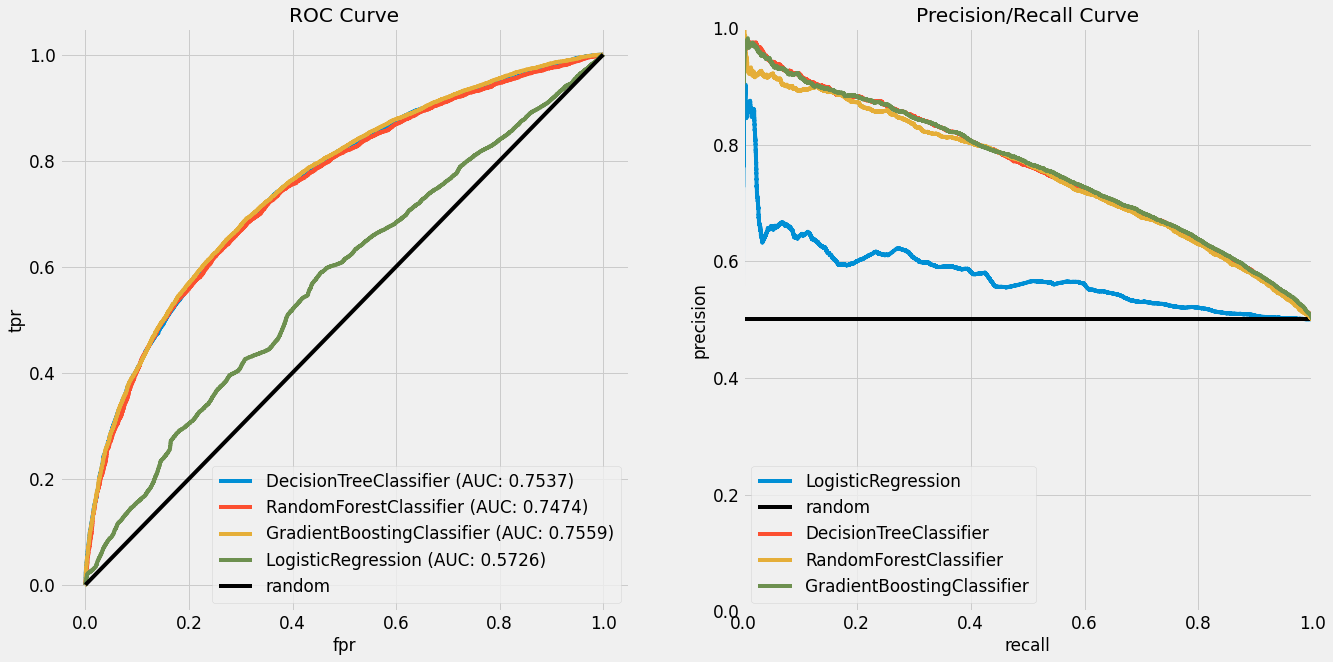

In [599]:
#ROC Curve
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
plot_roc(ax1, dt_df,dt_model)
plot_roc(ax1, rf_df,rf_model)
plot_roc(ax1, gb_df,gb_model)
plot_roc(ax1, log_reg_df,log_reg,True)

plot_precision_recall(ax2, log_reg_df,log_reg,True)
plot_precision_recall(ax2, dt_df,dt_model)
plot_precision_recall(ax2, rf_df,rf_model)
plot_precision_recall(ax2, gb_df,gb_model)

Text(0.5, 1.0, 'Confusion Matrix with Optimal Threshold')

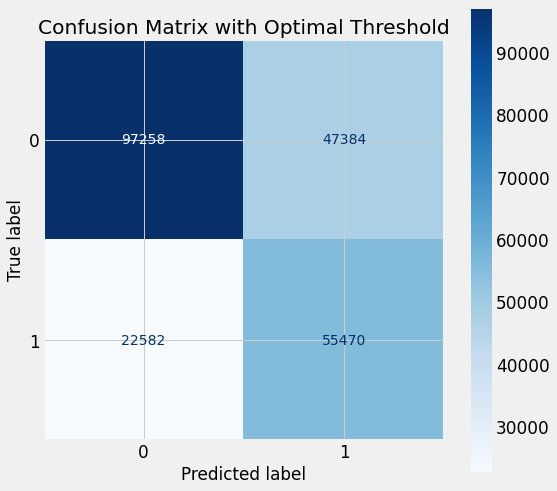

In [365]:
cm = confusion_matrix1(gb_model, X,y, 0.32)

fig, ax = plt.subplots(figsize = (8,8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.to_numpy())
disp.plot(cmap = plt.cm.Blues, ax = ax)
ax.set_title('Confusion Matrix with Optimal Threshold')

# EDA

In [ ]:
ax = df.groupby(['Division'])['T_No'].mean().plot.bar()
for p in ax.patches:
    ax.annotate((round(p.get_height(),3)), (p.get_x()+p.get_width()/3., p.get_height()*1.005),fontsize='large')
ax.set_title('Average Number of Playweeks by Division')

In [ ]:
def plot_hist_mean(grouped,target,bins=10):
    plot = df.groupby(grouped)[target].mean()
    fig,ax = plt.subplots()
    ax.hist(avg_bo,bins=bins); 

In [ ]:
plot_hist_mean('Division','Boxoffice',bins=50)

In [ ]:
avg_bo = df.groupby('City')['Boxoffice'].mean()
fig,ax = plt.subplots()
ax.hist(avg_bo,bins=10);


In [ ]:
avg_bo_adm = df.groupby('Theatre')[['Boxoffice','Admissions']].mean().sort_values(by='Boxoffice',ascending=False)
avg_bo_adm

In [ ]:
fig,ax = plt.subplots()
%time ax.scatter(avg_bo_adm.Admissions, avg_bo_adm.Boxoffice, alpha=0.5)
ax.set_title('Distribution of Avg Theatre Boxoffice')
ax.set_xlim(0,4000)
ax.set_ylabel('Average Boxoffice')
ax.set_xlabel('Average Admissions')
fig.tight_layout()

In [ ]:
avg_theatre.sort_values(by='Boxoffice',ascending=False).head(10)

In [ ]:
avg_theatre.sort_values(by='Boxoffice',ascending=True).head(10)

In [ ]:
df.groupby('Release')['Boxoffice'].mean().sort_values(ascending=True).tail(10).plot.barh(figsize=(10,7))
plt.xlabel('Average Location Gross')
plt.title('Top 10 Films by Avg Loc Gross')

# Clustering Data

In [96]:
import itertools
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [998]:
def plot_elbow_sil(df,maxk):
    maxk = maxk
    wcss = []
    sil_scores = []
    for i in tqdm(range(2, maxk)):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
        kmeans.fit(df)
        ypred=kmeans.predict(df)
        wcss.append(kmeans.inertia_)    
        labels = kmeans.labels_
        
        score = silhouette_score(df, labels, metric = 'euclidean')
        sil_scores.append(score)
    plt.plot(range(2, maxk), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Plot Plots
    fig, ax = plt.subplots(figsize=(maxk,10))
    ax.plot(range(2,maxk), sil_scores, 'o-')
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Silhouette score")

In [1488]:
fm = full_movie.copy()
fm.set_index('TITLE',inplace=True)
num_cols = fm.columns[fm.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
scale = StandardScaler()
fm[num_cols]=scale.fit_transform(fm[num_cols])
fm_1hot = pd.get_dummies(fm[['Genre','Season','Rating']],drop_first = True)
fm_1hot
fm_full = fm.join(fm_1hot,how='left')
fm_full = fm_full.drop(['Genre','Season','Rating'],axis=1)
fm_full

,# of Runs,budget,runtime,Boxoffice_Total,OW to YT,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter,Rating_PG13,Rating_R
TITLE,,,,,,,,,,,,,,,,,,,,,
Chips,-1.434362,-0.712037,-0.768135,-0.835831,-0.352320,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
Lego Batman Movie - 3D/IMAX,0.898109,0.189007,-0.563804,0.461075,0.057539,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Fist Fight,-0.398825,-0.761185,-1.227881,-0.659116,-0.169710,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
Unforgettable,-1.501866,-0.925012,-0.768135,-0.946962,-0.489616,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
Kong: Skull Island - 3D/IMAX,0.550536,1.909183,0.151357,0.912890,0.078505,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Joker - IMAX,1.308876,-0.220559,0.355688,2.334977,-0.513964,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
Doctor Sleep,0.563462,-0.384385,1.888175,-0.649206,-0.577540,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
Motherless Brooklyn,-3.045835,-0.695655,1.530595,-0.984245,-0.743918,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


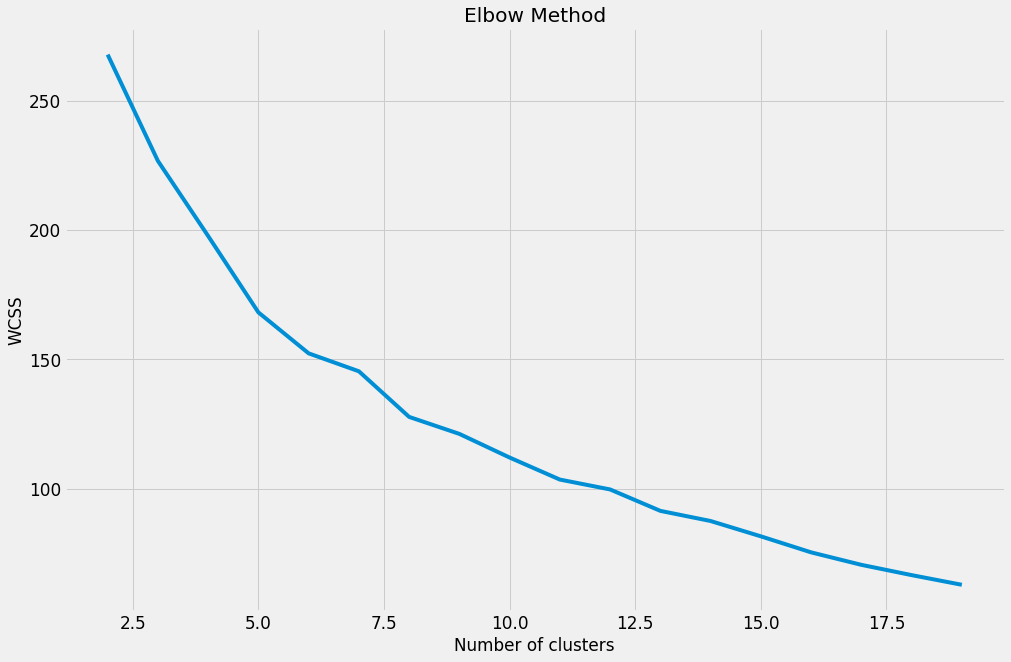

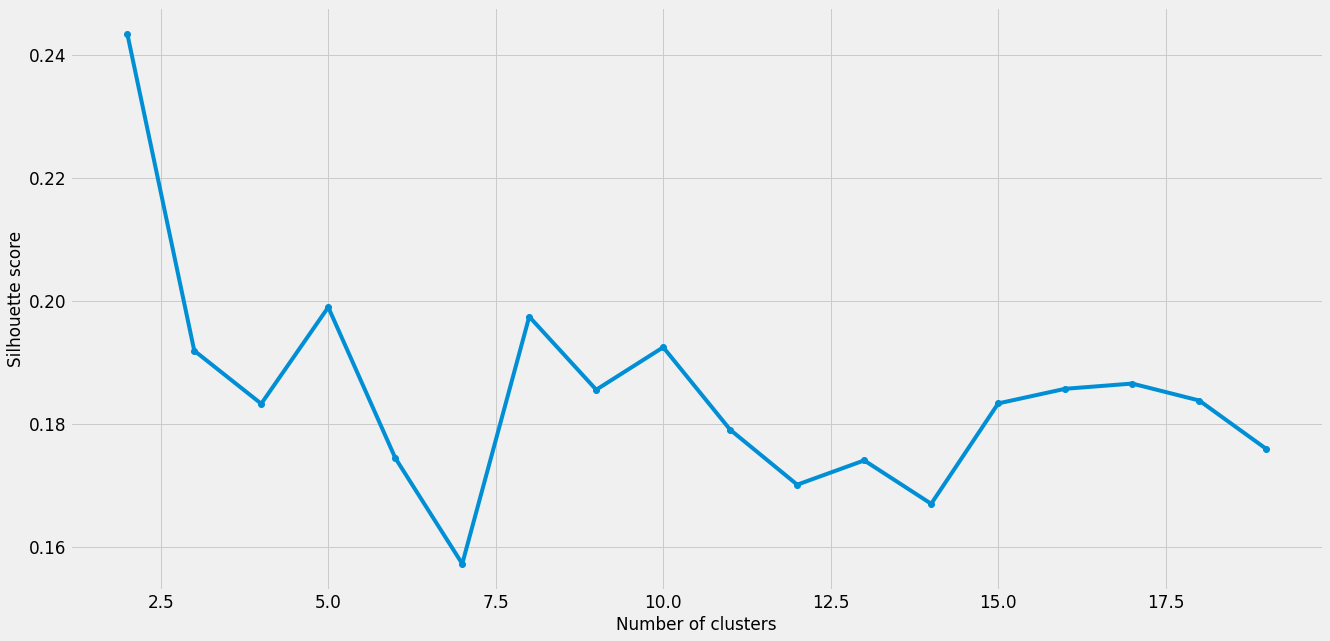

In [1489]:
plot_elbow_sil(fm_full,20)

In [1490]:
#Genre + Movie Clustering
fm_cluster = KMeans(n_clusters=5, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = fm_cluster.fit_predict(fm_full)
fm_full['clusters']=pred_y

cluster_test = fm_full['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

TITLE
Dunkirk - IMAX                                        0
Ready Player One - 3D/IMAX                            0
Justice League - 3D/IMAX                              0
Rampage - NL - 3D/IMAX                                0
Pokemon Detective Pikachu - 3D                        0
Ocean's 8                                             0
Meg, The - 3D/IMAX                                    0
Godzilla: King Of The Monsters - 3D/IMAX              0
Tomb Raider - MGM - 3D/IMAX                           0
King Arthur: Legend Of The Sword - 3D                 0
Kong: Skull Island - 3D/IMAX                          0
Aquaman - 3D/IMAX                                     0
Shazam! - 3D/IMAX                                     0
Wonder Woman - 3D/IMAX                                0
Crazy Rich Asians                                     1
Nun, The - IMAX                                       1
Teen Titans Go! To The Movies                         1
Smallfoot (Ani) - 3D                      

In [1491]:
fm_num = fm.drop(['Genre','Season','Rating'],axis=1)

fm_std = (fm_num-np.mean(fm_num))/np.std(fm_num)
n_components = 2
fm_pca = PCA(n_components=n_components).fit_transform(fm_std.values)
fm_pca

array([[-1.84370467, -0.54627175],
       [ 0.60503682,  0.66464362],
       [-1.41923942,  0.20479644],
       [-2.03995684, -0.68174493],
       [ 1.83773568,  0.18222225],
       [-1.55405569,  1.76187087],
       [ 1.05025898, -0.90896586],
       [-1.77157129,  0.31861194],
       [ 3.1984239 , -0.14133375],
       [-1.40771395,  0.24306767],
       [ 0.6669368 ,  0.11545419],
       [-0.47537145,  0.33345898],
       [ 2.1763405 ,  0.8086869 ],
       [-0.07573962,  0.37964676],
       [ 2.11942023, -1.24199286],
       [-0.19635009, -0.32340647],
       [-1.08716649,  4.59924126],
       [ 3.74484076, -0.19446767],
       [-1.01191768, -1.29242862],
       [-0.67708368, -0.42710813],
       [-1.6230972 ,  2.37863387],
       [-0.84055946,  0.60368393],
       [ 0.39731549, -0.13739832],
       [ 2.34309905, -0.39687576],
       [ 0.82133981,  0.11934099],
       [-0.69983976,  0.91801297],
       [-0.99019721,  0.48926689],
       [ 0.64400555,  0.58726656],
       [-1.60490983,

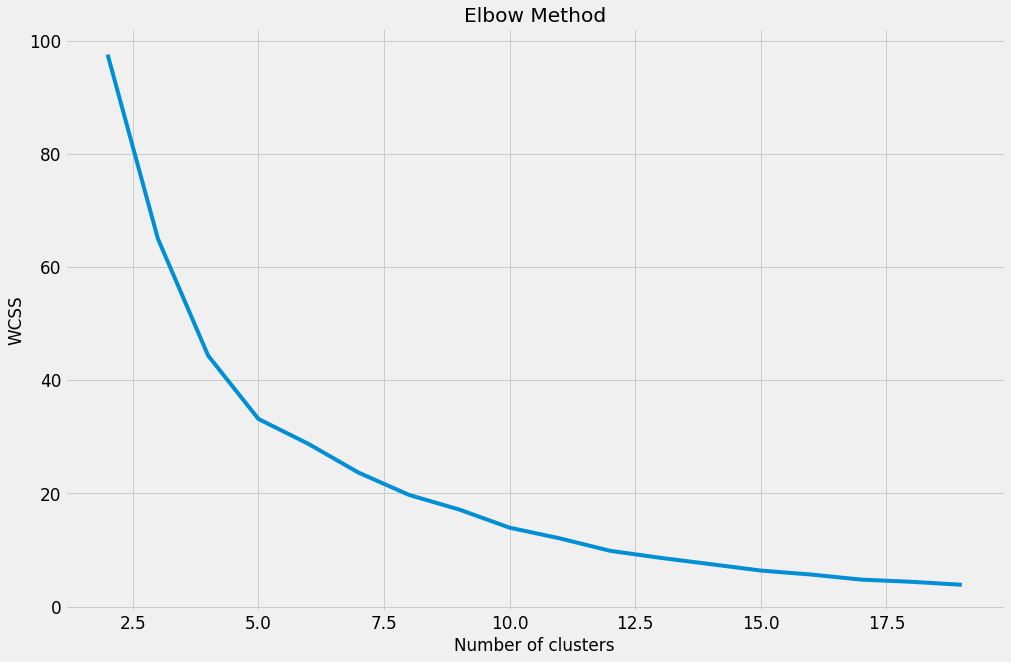

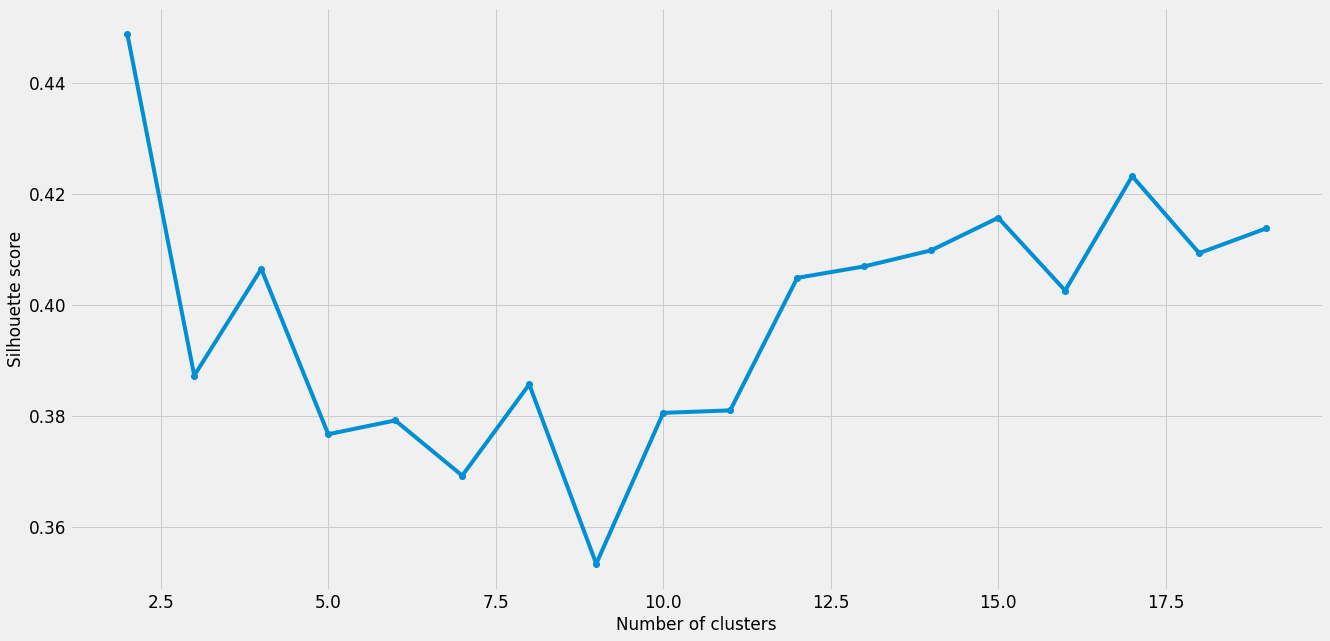

In [1492]:
plot_elbow_sil(fm_pca,20)

Text(0, 0.5, 'Second Principal Component')

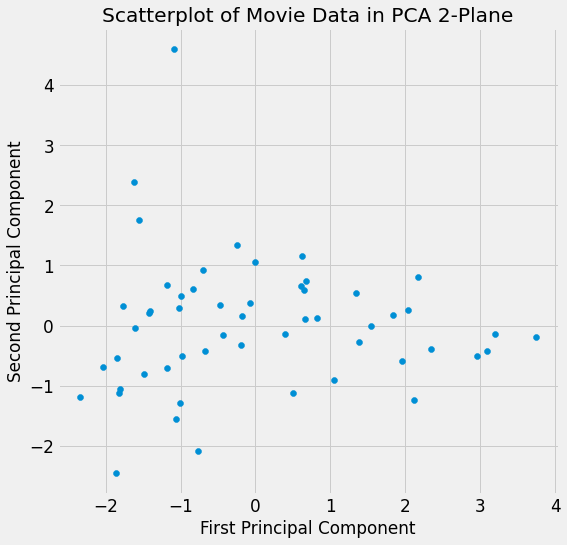

In [1493]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(fm_pca[:, 0], fm_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

In [1494]:
#Movie_PCA Clustering

fm_pca_df = pd.DataFrame(fm_pca, columns = ('PCA1','PCA2'))
fm_pca_df = fm_pca_df.join(fm,how='right')

fmpca_cluster = KMeans(n_clusters=17, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = fmpca_cluster.fit_predict(fm_pca)
fm_pca_df['clusters']=pred_y

cluster_test = fm_pca_df['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

TITLE
Kitchen, The                                           0
SHAFT (2074539)                                        0
Mule, The                                              0
12 Strong - IMAX                                       0
It (NL)                                                1
Nun, The - IMAX                                        2
Smallfoot (Ani) - 3D                                   2
Godzilla: King Of The Monsters - 3D/IMAX               3
Ready Player One - 3D/IMAX                             3
Blade Runner 2049 - Alcon - 3D/IMAX                    3
Going In Style                                         4
15:17 To Paris, The                                    4
Fist Fight                                             5
Everything, Everything                                 5
House, The                                             5
Teen Titans Go! To The Movies                          5
Ocean's 8                                              6
Star Is Born, A          

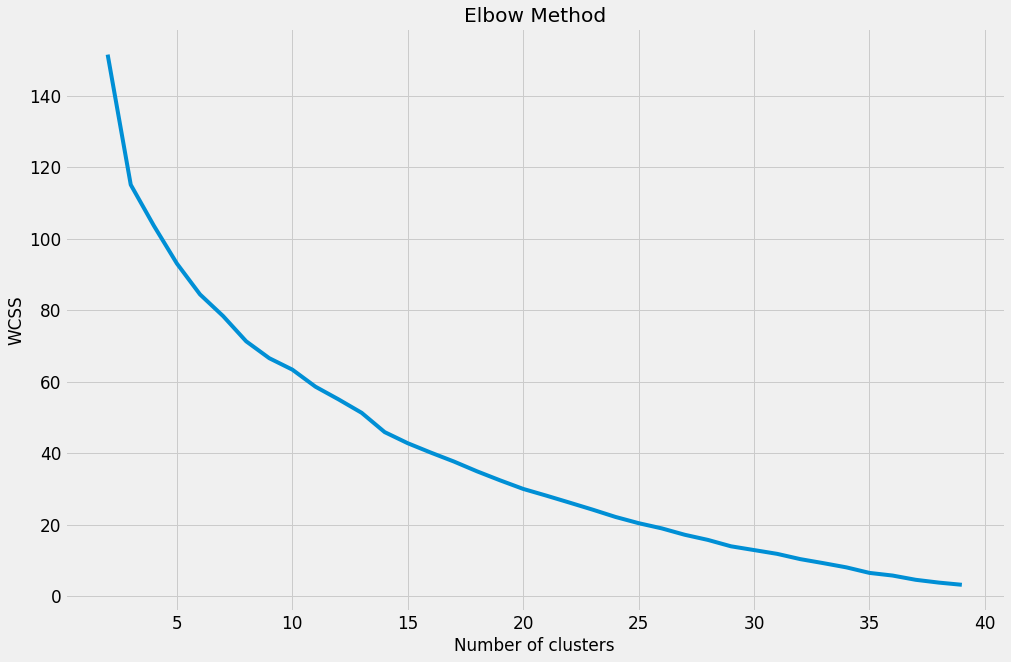

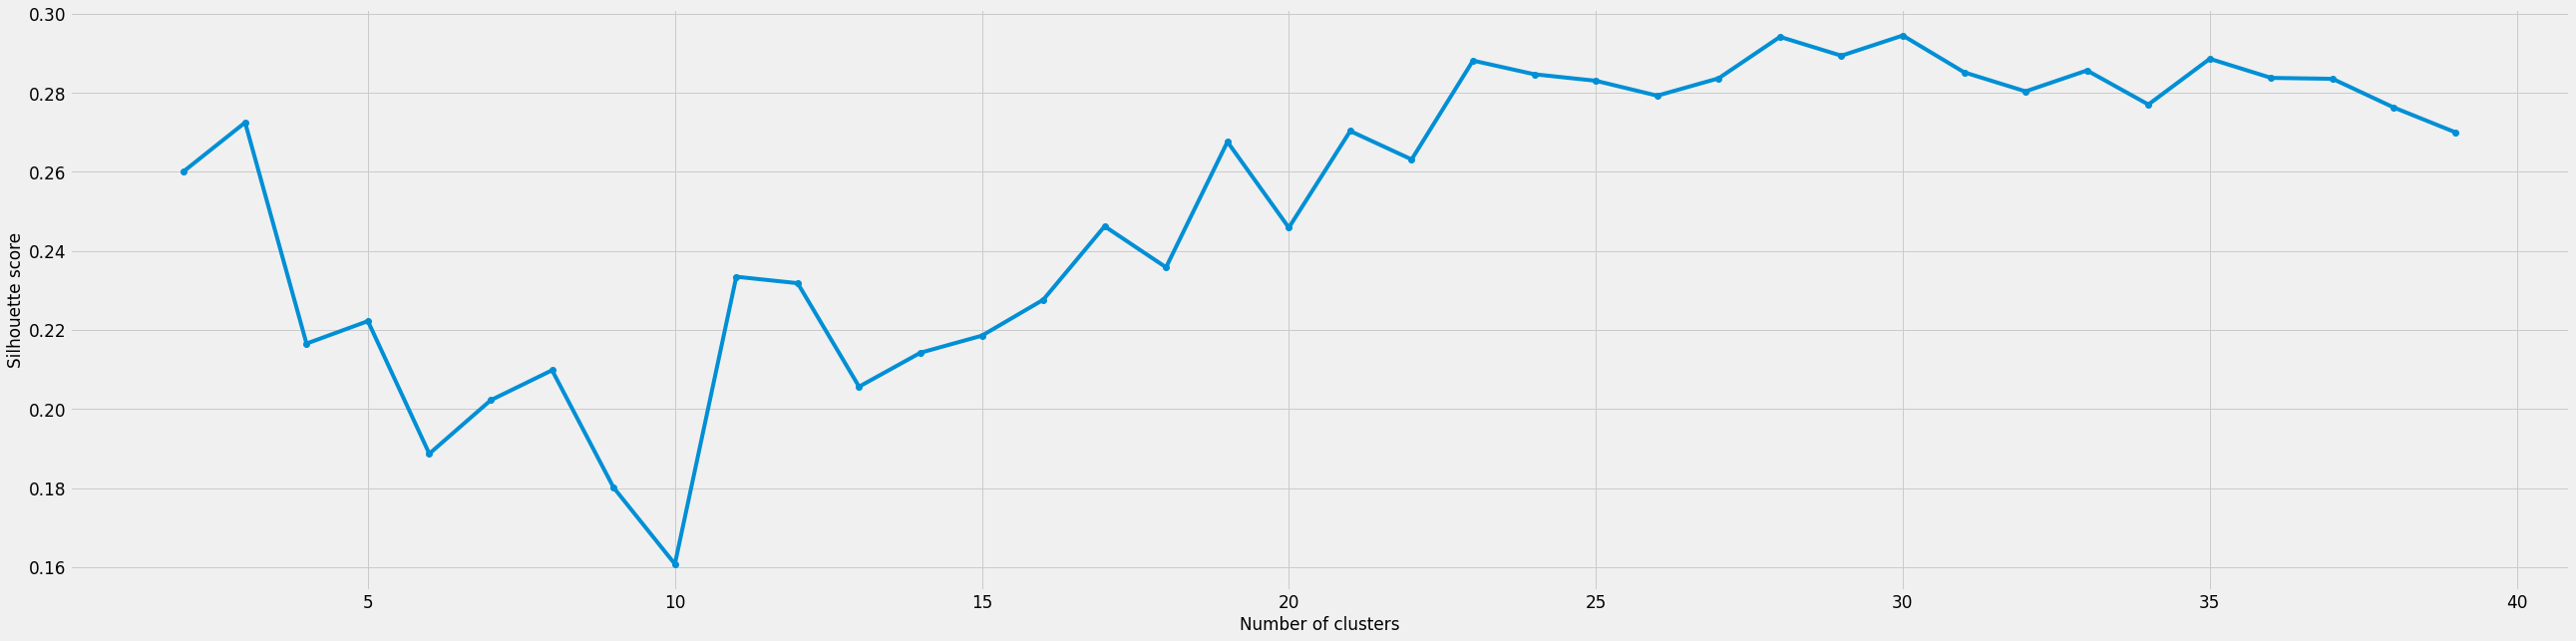

In [1519]:
fm_nobo = fm_full.drop(['# of Runs','Boxoffice_Total','OW to YT','clusters'],axis=1)
plot_elbow_sil(fm_nobo,40)

In [1521]:
#No BO Clustering

nobo_cluster = KMeans(n_clusters=28, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = nobo_cluster.fit_predict(fm_nobo)
fm_nobo['clusters']=pred_y

cluster_test = fm_nobo['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

TITLE
Kong: Skull Island - 3D/IMAX                           0
Rampage - NL - 3D/IMAX                                 0
Tag                                                    1
House, The                                             1
Star Is Born, A                                        2
Joker - IMAX                                           2
Goldfinch, The                                         2
Ocean's 8                                              3
Dunkirk - IMAX                                         3
Doctor Sleep                                           4
Going In Style                                         5
Life Of The Party                                      5
Lego Movie 2, The: The Second Part (Ani) - 3D/IMAX     6
Lego Batman Movie - 3D/IMAX                            6
Aquaman - 3D/IMAX                                      7
Ready Player One - 3D/IMAX                             7
Curse Of La Llorona, The                               8
Nun, The - IMAX          

# NLP on Plot Overview

In [726]:
import string
import unicodedata

import nltk

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser



def extract_bow_from_raw_text(text_as_string):
    """Extracts bag-of-words from a raw text string.

    Parameters
    ----------
    text (str): a text document given as a string

    Returns
    -------
    list : the list of the tokens extracted and filtered from the text
    """
    if (text_as_string == None):
        return []

    if (len(text_as_string) < 1):
        return []

    nfkd_form = unicodedata.normalize('NFKD', text_as_string)
    text_input = str(nfkd_form.encode('ASCII', 'ignore'))

    sent_tokens = sent_tokenize(text_input)

    tokens = list(map(word_tokenize, sent_tokens))

    sent_tags = list(map(pos_tag, tokens))

    grammar = r"""
        SENT: {<(J|N).*>}                # chunk sequences of proper nouns
    """

    cp = RegexpParser(grammar)
    ret_tokens = list()
    #lemmatizer = WordNetLemmatizer()
    stemmer_snowball = SnowballStemmer('english')

    for sent in sent_tags:
        tree = cp.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'SENT':
                t_tokenlist = [tpos[0].lower() for tpos in subtree.leaves()]
                #t_tokens_lemma = list(map(lemmatizer.lemmatize, t_tokenlist))
                t_tokens_stemsnowball = list(map(stemmer_snowball.stem, t_tokenlist))
    
                ret_tokens.extend(t_tokens_stemsnowball)

    return(ret_tokens)
    

In [1495]:
movie_text

0     The adventures of two California Highway Patro...
1     A cooler-than-ever Bruce Wayne must deal with ...
2     When one school teacher gets the other fired, ...
3     Julia moves in with her fiancé, David, but his...
4     Explore the mysterious and dangerous home of t...
                            ...                        
49    During the 1980s, a failed stand-up comedian i...
50    Still irrevocably scarred by the trauma he end...
51    New York City, 1957. Lionel Essrog, a private ...
52    Career con man Roy sets his sights on his late...
53    Richard Jewell thinks quick, works fast, and s...
Name: overview, Length: 54, dtype: object

In [1496]:
docs = []
for desc in tqdm(movie_text):
    docs.append(desc)

In [1497]:
# extracting bows
bows = list(map(lambda row: extract_bow_from_raw_text(row), docs))

In [1498]:
# displaying bows
for i in range(len(docs)):
    print("\n--- Plot: {}".format(docs[i]))
    print("--- BoW: {}".format(bows[i]))


--- Plot: The adventures of two California Highway Patrol motorcycle officers as they make their rounds on the freeways of Los Angeles.
--- BoW: ["b'the", 'adventur', 'california', 'highway', 'patrol', 'motorcycl', 'offic', 'round', 'freeway', 'los', 'angel']

--- Plot: A cooler-than-ever Bruce Wayne must deal with the usual suspects as they plan to rule Gotham City, while discovering that he has accidentally adopted a teenage orphan who wishes to become his sidekick.
--- BoW: ['b', 'cooler-than-ev', 'bruce', 'wayn', 'usual', 'suspect', 'gotham', 'citi', 'teenag', 'orphan', 'sidekick']

--- Plot: When one school teacher gets the other fired, he is challenged to an after-school fight.
--- BoW: ["b'when", 'school', 'other', 'after-school', 'fight']

--- Plot: Julia moves in with her fiancé, David, but his ex-wife and her own haunting past join forces to rock her quiet suburban existence.
--- BoW: ["b'julia", 'move', 'fianc', 'david', 'ex-wif', 'own', 'haunt', 'join', 'forc', 'quiet', 's

In [1499]:
from collections import Counter

# term occurence = counting distinct words in each bag
term_occ = list(map(lambda bow : Counter(bow), bows))

# term frequency = occurences over length of bag
term_freq = list()
for i in range(len(docs)):
    term_freq.append( {k: (v / float(len(bows[i])))
                       for k, v in term_occ[i].items()} )

# displaying occurences
for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- term_occ: {}".format(term_occ[i]))
    print("--- term_freq: {}".format(term_freq[i]))


--- review: The adventures of two California Highway Patrol motorcycle officers as they make their rounds on the freeways of Los Angeles.
--- bow: ["b'the", 'adventur', 'california', 'highway', 'patrol', 'motorcycl', 'offic', 'round', 'freeway', 'los', 'angel']
--- term_occ: Counter({"b'the": 1, 'adventur': 1, 'california': 1, 'highway': 1, 'patrol': 1, 'motorcycl': 1, 'offic': 1, 'round': 1, 'freeway': 1, 'los': 1, 'angel': 1})
--- term_freq: {"b'the": 0.09090909090909091, 'adventur': 0.09090909090909091, 'california': 0.09090909090909091, 'highway': 0.09090909090909091, 'patrol': 0.09090909090909091, 'motorcycl': 0.09090909090909091, 'offic': 0.09090909090909091, 'round': 0.09090909090909091, 'freeway': 0.09090909090909091, 'los': 0.09090909090909091, 'angel': 0.09090909090909091}

--- review: A cooler-than-ever Bruce Wayne must deal with the usual suspects as they plan to rule Gotham City, while discovering that he has accidentally adopted a teenage orphan who wishes to become his 

In [1500]:
# document occurence = number of documents having this word
# term frequency = occurences over length of bag

doc_occ = Counter( [word for bow in bows for word in set(bow)] )

# document frequency = occurences over length of corpus
doc_freq = {k: (v / float(len(docs)))
            for k, v in doc_occ.items()}

# displaying vocabulary
print("\n--- full vocabulary: {}".format(doc_occ))
print("\n--- doc freq: {}".format(doc_freq))


--- full vocabulary: Counter({'b': 24, 'friend': 9, 'own': 8, 'life': 7, 'world': 7, 'new': 7, 'everyth': 6, 'year': 6, 'citi': 5, 'forc': 5, 'home': 5, 'boy': 5, 'live': 5, 'teenag': 4, 'team': 4, 'first': 4, 'human': 4, 'daughter': 4, 'monster': 4, 'young': 4, 'york': 4, 'famili': 4, 'bruce': 3, "b'when": 3, 'other': 3, 'school': 3, 'king': 3, 'island': 3, 'love': 3, 'father': 3, 'stone': 3, 'arthur': 3, 'way': 3, 'man': 3, 'dream': 3, 'colleg': 3, 'night': 3, 'day': 3, 'seri': 3, 'earth': 3, 'threat': 3, 'mother': 3, 'brother': 3, 'agent': 3, 'peopl': 3, 'member': 3, 'game': 3, 'head': 3, 'best': 3, 'crime': 3, 'offic': 2, 'adventur': 2, "b'the": 2, 'gotham': 2, 'wayn': 2, 'sidekick': 2, 'exist': 2, 'suburban': 2, 'ape': 2, 'mysteri': 2, 'deep': 2, 'money': 2, 'pal': 2, 'child': 2, 'idea': 2, 'true': 2, 'door': 2, 'evil': 2, 'war': 2, 'help': 2, 'major': 2, 'need': 2, 'armi': 2, 'britain': 2, 'alli': 2, 'sever': 2, 'littl': 2, 'nun': 2, 'target': 2, 'doll': 2, 'death': 2, 'children

In [1501]:
# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.04

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),sorted(vocabulary)))

-- vocabulary (len=50): ['agent', 'arthur', 'b', "b'when", 'best', 'boy', 'brother', 'bruce', 'citi', 'colleg', 'crime', 'daughter', 'day', 'dream', 'earth', 'everyth', 'famili', 'father', 'first', 'forc', 'friend', 'game', 'head', 'home', 'human', 'island', 'king', 'life', 'live', 'love', 'man', 'member', 'monster', 'mother', 'new', 'night', 'other', 'own', 'peopl', 'school', 'seri', 'stone', 'team', 'teenag', 'threat', 'way', 'world', 'year', 'york', 'young']


In [1502]:
import numpy as np

# create a dense matrix of vectors for each document
# each vector has the length of the vocabulary
vectors = np.zeros((len(docs),len(vocabulary)))

# fill these vectors with tf-idf values
for i in range(len(docs)):
    for j in range(len(vocabulary)):
        term     = vocabulary[j]
        term_tf  = term_freq[i].get(term, 0.0)   # 0.0 if term not found in doc
        term_idf = np.log(1 + 1 / doc_freq[term]) # smooth formula
        vectors[i,j] = term_tf * term_idf

# displaying results
'''for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- tfidf vector: {}".format( vectors[i] ) )
    print("--- tfidf sorted: {}".format( 
            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )
         ))
         '''

'for i in range(len(docs)):\n    print("\n--- review: {}".format(docs[i]))\n    print("--- bow: {}".format(bows[i]))\n    print("--- tfidf vector: {}".format( vectors[i] ) )\n    print("--- tfidf sorted: {}".format( \n            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )\n         ))\n         '

In [1503]:
mv_tfidf = pd.DataFrame(data=vectors,columns=sorted(vocabulary))
mv_tfidf = mv_tfidf.rename(columns={"b'in":'in',"b'the":'the',"b'when":'when'})
mv_tfidf.drop('b',axis=1,inplace=True)

mv_tfidf

,agent,arthur,when,best,boy,brother,bruce,citi,colleg,crime,daughter,day,dream,earth,everyth,famili,father,first,forc,friend,game,head,home,human,island,king,life,live,love,man,member,monster,mother,new,night,other,own,peopl,school,seri,stone,team,teenag,threat,way,world,year,york,young
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,0.243104,0.107150,0.224373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.588888,0.588888,0.588888,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170641,0.205675,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205675,0.24537,0.24537,0.222846,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,0.000000,0.000000,0.189854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.166536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.452991
50,0.102852,0.045333,0.000000,0.000000,0.000000,0.000000,0.078757,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
51,0.000000,0.000000,0.123405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.097296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133707,0.147222,0.123405,0.0,0.000000
52,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184027,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


# Sklearn TFIDF

In [753]:
corpus = [row for row in docs]
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(stop_words='english')

document_tf_matrix = tf.fit_transform(corpus).todense()

sorted(tf.vocabulary_);
document_tf_matrix;

from math import log

def idf(frequency_matrix):
    df =  float(len(document_tf_matrix)) / sum(frequency_matrix > 0)
    return [log(i) for i in df.getA()[0]]
sorted(tf.vocabulary_);
idf(document_tf_matrix);

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
document_tfidf_matrix = tfidf.fit_transform(corpus)
#print(tfidf.vocabulary_)
print(document_tfidf_matrix.todense())

# PCA

In [1504]:
from sklearn.decomposition import PCA
mv_tfidf_std = (mv_tfidf-np.mean(mv_tfidf))/np.std(mv_tfidf)
n_components = 2
mv_tfidf_pca = PCA(n_components=n_components).fit_transform(mv_tfidf_std.values)
#mv_tf_pca = movies_tfidf_std.values @ pca.components_.T
mv_tfidf_pca

array([[-2.09862072e-02,  3.21058366e-01],
       [-1.69518534e+00, -1.36197634e+00],
       [ 1.06768185e-01,  9.68817242e+00],
       [-3.47110013e-01,  2.59492110e-01],
       [ 5.08306500e+00,  1.24917549e+00],
       [-6.45740867e-01,  5.23138208e-01],
       [ 3.52431161e+00, -3.24303215e+00],
       [-2.88649384e+00, -2.55445284e+00],
       [ 2.83531592e+00, -5.81074111e-01],
       [-2.85450374e-01,  1.67648479e+00],
       [ 2.16549159e-01,  1.68199363e-01],
       [ 7.05603550e-01,  1.92426131e-02],
       [-4.04396008e-01, -1.44442655e-01],
       [ 3.47115786e-01,  1.89644044e+00],
       [-5.88000669e-03, -4.82546091e-01],
       [ 5.60543577e-01, -1.47905773e+00],
       [-4.80604933e-01,  3.14734202e-01],
       [ 3.06569129e+00, -2.60579879e+00],
       [ 3.92049973e+00, -1.86671762e+00],
       [ 1.74136805e+00, -1.92359259e-01],
       [ 3.01254001e-01,  1.39793912e+00],
       [-5.67044975e-02,  1.01901559e+00],
       [ 3.35611649e+00,  1.44863008e+00],
       [ 3.

Text(0, 0.5, 'Second Principal Component')

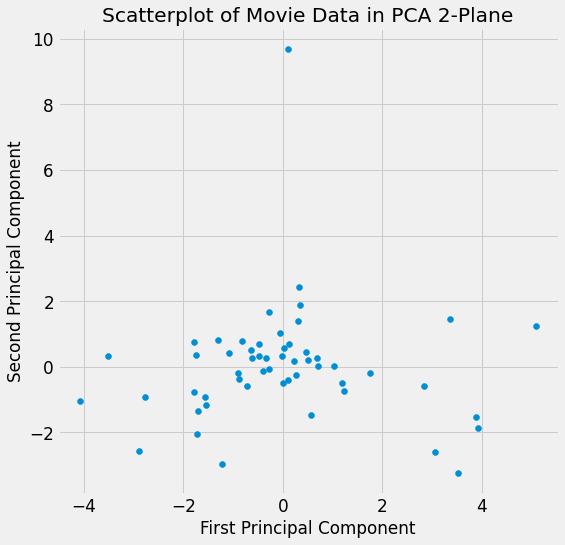

In [1505]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(mv_tfidf_pca[:, 0], mv_tfidf_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

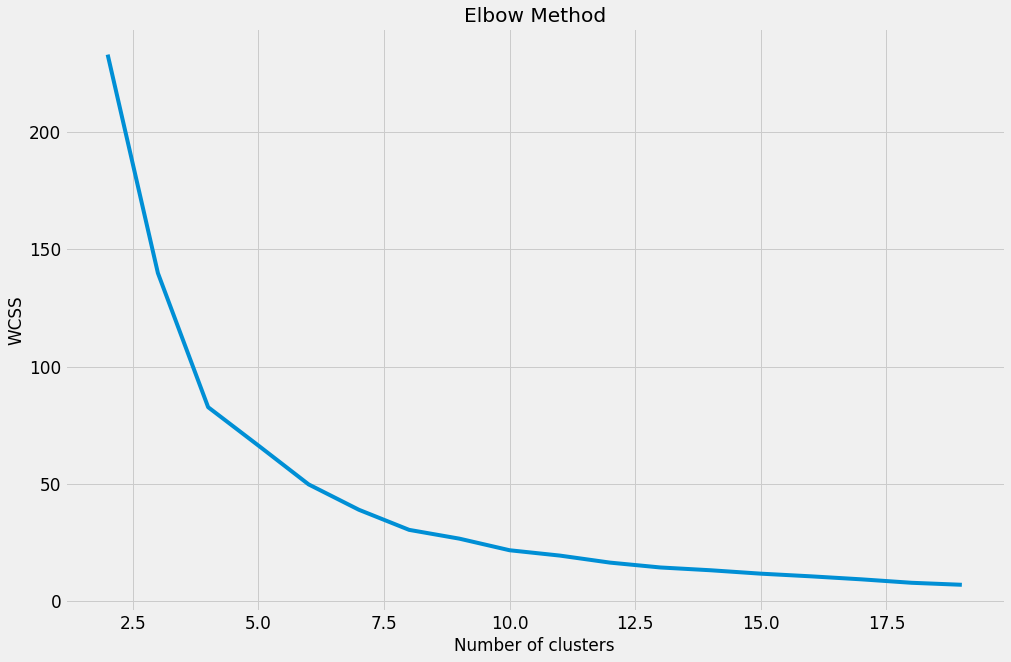

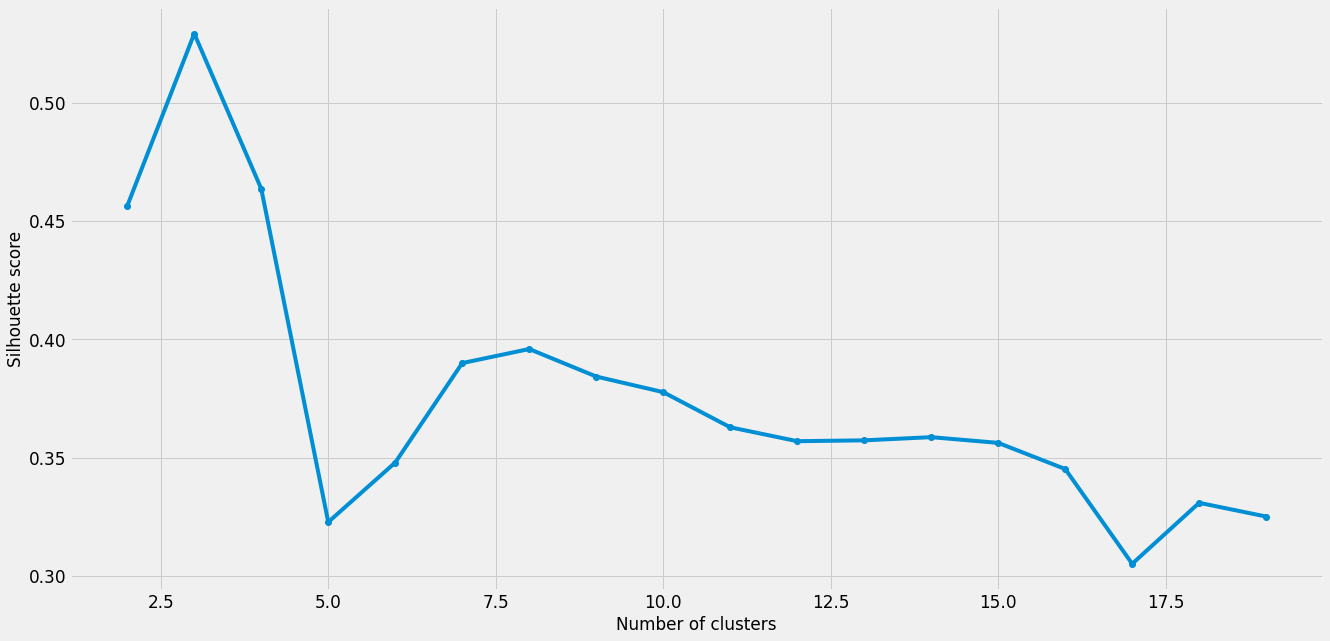

In [1506]:
plot_elbow_sil(mv_tfidf_pca,20)

In [1507]:
with pd.option_context("display.max_rows", 1000):
    display(genre_df['TITLE'])

0                                                 Chips
1                           Lego Batman Movie - 3D/IMAX
2                                            Fist Fight
3                                         Unforgettable
4                          Kong: Skull Island - 3D/IMAX
5                                        Going In Style
6                 King Arthur: Legend Of The Sword - 3D
7                                Everything, Everything
8                                Wonder Woman - 3D/IMAX
9                                            House, The
10                                       Dunkirk - IMAX
11                                  Annabelle: Creation
12                                              It (NL)
13                   Lego Ninjago Movie, The (Ani) - 3D
14                  Blade Runner 2049 - Alcon - 3D/IMAX
15                                   Geostorm - 3D/IMAX
16                                         Paddington 2
17                             Justice League - 

In [1508]:
#Movie Clustering + Genre DF for title
pca_cluster = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = pca_cluster.fit_predict(mv_tfidf_pca)

mv_pca = pd.DataFrame(mv_tfidf_pca, columns = ('PCA1','PCA2'))
mv_pca = mv_pca.join(genre_df['TITLE'],how='left')
mv_pca.set_index('TITLE',inplace=True)
mv_pca['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca['clusters']

with pd.option_context("display.max_rows", 1000):
    display(tfidf_cluster_.sort_values())

TITLE
Tomb Raider - MGM - 3D/IMAX                           0
Kong: Skull Island - 3D/IMAX                          0
Curse Of La Llorona, The                              1
Goldfinch, The                                        1
Ocean's 8                                             1
Joker - IMAX                                          1
Everything, Everything                                1
Blinded By The Light                                  1
Lego Movie 2, The: The Second Part (Ani) - 3D/IMAX    1
Isn't It Romantic                                     1
Sun Is Also A Star, The                               1
Lego Batman Movie - 3D/IMAX                           1
House, The                                            2
Game Night                                            2
Lego Ninjago Movie, The (Ani) - 3D                    2
Life Of The Party                                     2
15:17 To Paris, The                                   2
Godzilla: King Of The Monsters - 3D/IMAX  

In [1522]:
# Text PCA + No Boxoffice Dataframe 
mv_pca_full = mv_pca.join(fm_nobo,how='left',rsuffix='_x')
mv_pca_full.drop(['clusters','clusters_x'],axis=1,inplace=True)


#scale = StandardScaler()
#runtime = mv_pca_full['ow_by_runtime']
#transform = scale.fit_transform(runtime.values.reshape(-1,1))
#mv_pca_full['ow_by_runtime']= transform

mv_pca_full

,PCA1,PCA2,budget,runtime,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter,Rating_PG13,Rating_R
TITLE,,,,,,,,,,,,,,,,,,,,
Chips,-0.020986,0.321058,-0.712037,-0.768135,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
Lego Batman Movie - 3D/IMAX,-1.695185,-1.361976,0.189007,-0.563804,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Fist Fight,0.106768,9.688172,-0.761185,-1.227881,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
Unforgettable,-0.347110,0.259492,-0.925012,-0.768135,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
Kong: Skull Island - 3D/IMAX,5.083065,1.249175,1.909183,0.151357,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Joker - IMAX,-1.535478,-1.176897,-0.220559,0.355688,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
Doctor Sleep,-0.892742,-0.196771,-0.384385,1.888175,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
Motherless Brooklyn,-1.752919,0.345280,-0.695655,1.530595,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [1523]:
with pd.option_context("display.max_rows", 1000):
    display(mv_pca_full)

,PCA1,PCA2,budget,runtime,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter,Rating_PG13,Rating_R
TITLE,,,,,,,,,,,,,,,,,,,,
Chips,-0.020986,0.321058,-0.712037,-0.768135,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
Lego Batman Movie - 3D/IMAX,-1.695185,-1.361976,0.189007,-0.563804,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Fist Fight,0.106768,9.688172,-0.761185,-1.227881,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
Unforgettable,-0.347110,0.259492,-0.925012,-0.768135,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
Kong: Skull Island - 3D/IMAX,5.083065,1.249175,1.909183,0.151357,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
Going In Style,-0.645741,0.523138,-0.712037,-0.972467,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
King Arthur: Legend Of The Sword - 3D,3.524312,-3.243032,1.745356,0.560020,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
"Everything, Everything",-2.886494,-2.554453,-0.957777,-0.972467,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
Wonder Woman - 3D/IMAX,2.835316,-0.581074,1.319408,1.326263,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


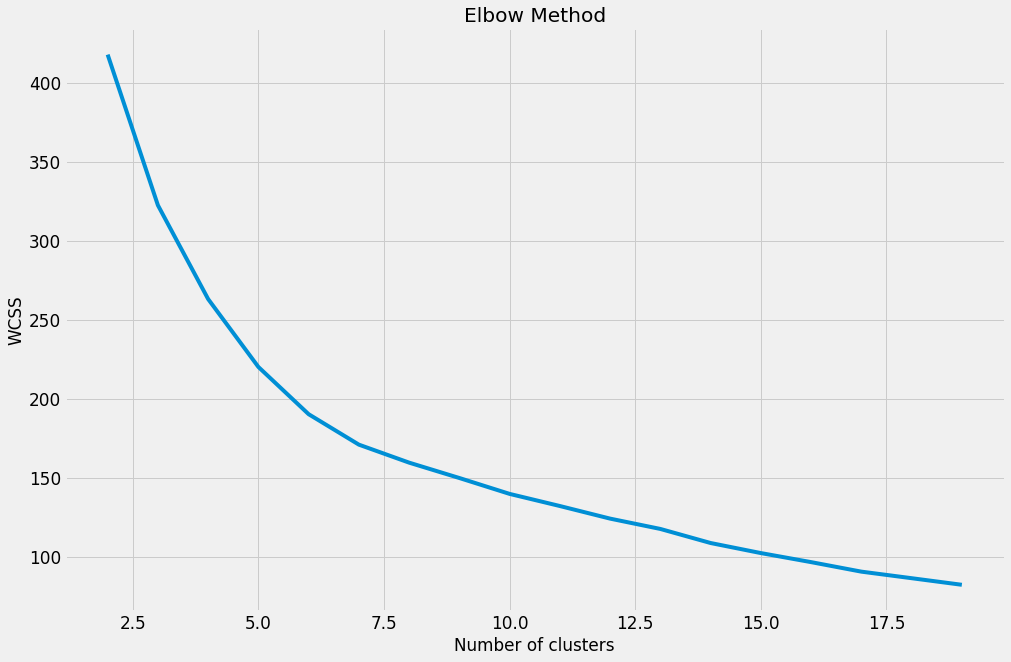

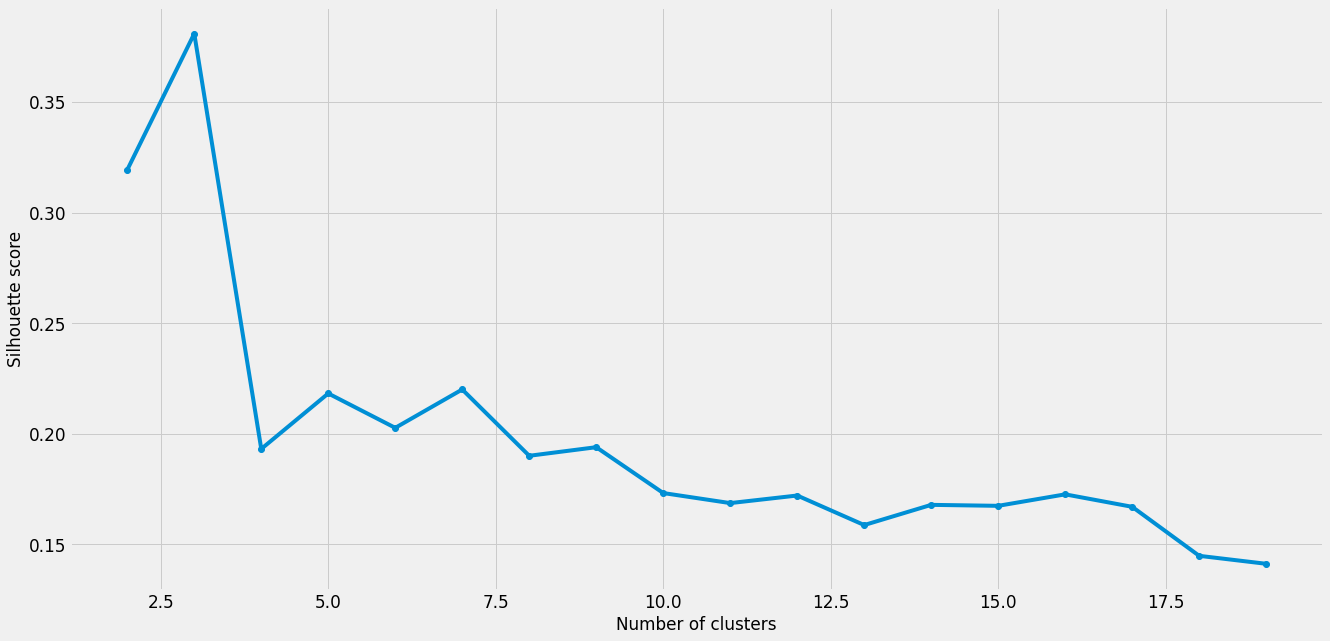

In [1524]:
plot_elbow_sil(mv_pca_full,20)

In [1525]:
#Movie Clustering
tfidf_cluster = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = tfidf_cluster.fit_predict(mv_pca_full)
mv_pca_full['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca_full['clusters']
with pd.option_context("display.max_rows", 1000):
    display(tfidf_cluster_.sort_values())

TITLE
Curse Of La Llorona, The                              0
Lego Batman Movie - 3D/IMAX                           0
Isn't It Romantic                                     0
Lego Movie 2, The: The Second Part (Ani) - 3D/IMAX    0
Everything, Everything                                0
Crazy Rich Asians                                     0
Sun Is Also A Star, The                               0
Ocean's 8                                             0
Blinded By The Light                                  0
Mule, The                                             1
Smallfoot (Ani) - 3D                                  1
Pokemon Detective Pikachu - 3D                        1
Meg, The - 3D/IMAX                                    1
Godzilla: King Of The Monsters - 3D/IMAX              1
Rampage - NL - 3D/IMAX                                1
Ready Player One - 3D/IMAX                            1
12 Strong - IMAX                                      1
Dunkirk - IMAX                            